In [1]:
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
from harp.clock import decode_harp_clock, align_timestamps_to_anchor_points
from open_ephys.analysis import Session
import datetime
from aind_ephys_rig_qc.temporal_alignment import search_harp_line
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from utils.plot_utils import combine_pdf_big

from open_ephys.analysis import Session
from pathlib import Path
import glob

import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from aind_dynamic_foraging_basic_analysis.plot.plot_foraging_session import plot_foraging_session
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from hdmf_zarr.nwb import NWBZarrIO
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
import pandas as pd
import pickle
import scipy.stats as stats
from joblib import Parallel, delayed
from multiprocessing import Pool
from functools import partial
import time
import spikeinterface as si
import shutil
import seaborn as sns
import math  
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import zscore
from utils.plot_utils import shiftedColorMap, interpolate_waveform
%matplotlib inline

In [2]:
criteria_name = 'waveform_2D_large'

In [3]:
# load constraints and data
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
with open(os.path.join('/root/capsule/scratch/combined/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)
wf_folder = os.path.join('/root/capsule/scratch/combined/wf_plots', criteria_name)
if not os.path.exists(wf_folder):
    os.makedirs(wf_folder)
# start with a mask of all True
mask = pd.Series(True, index=combined_tagged_units.index)

In [4]:
for col, cfg in constraints.items():
    if col not in combined_tagged_units.columns:
        continue

    # Numeric range?
    if "bounds" in cfg:
        print(f'Applying bounds for {col}: {cfg["bounds"]}')
        lb, ub = np.array(cfg["bounds"], dtype=float)  # np.nan for null
        if not np.isnan(lb):
            mask &= combined_tagged_units[col] >= lb
        if not np.isnan(ub):
            mask &= combined_tagged_units[col] <= ub

    # Categorical list?
    elif "items" in cfg:
        print(f'Applying items for {col}: {cfg["items"]}')
        allowed = cfg["items"]
        mask &= combined_tagged_units[col].isin(allowed)

# apply and get filtered DataFrame
combined_tagged_units_filtered = combined_tagged_units[mask].reset_index(drop=True)
combined_tagged_units['selected'] = mask
print(f'Number of units after filtering: {len(combined_tagged_units_filtered)}')

Applying bounds for isi_violations: [0.0, 0.5]
Applying bounds for p_max: [0.5, 1.0]
Applying bounds for lat_max_p: [0.005, 0.02]
Applying bounds for eu: [0.0, 0.25]
Applying bounds for corr: [0.95, 1.0]
Applying items for qc_pass: [True]
Applying bounds for peak: [-1000, -50]
Applying items for probe: ['2']
Number of units after filtering: 167


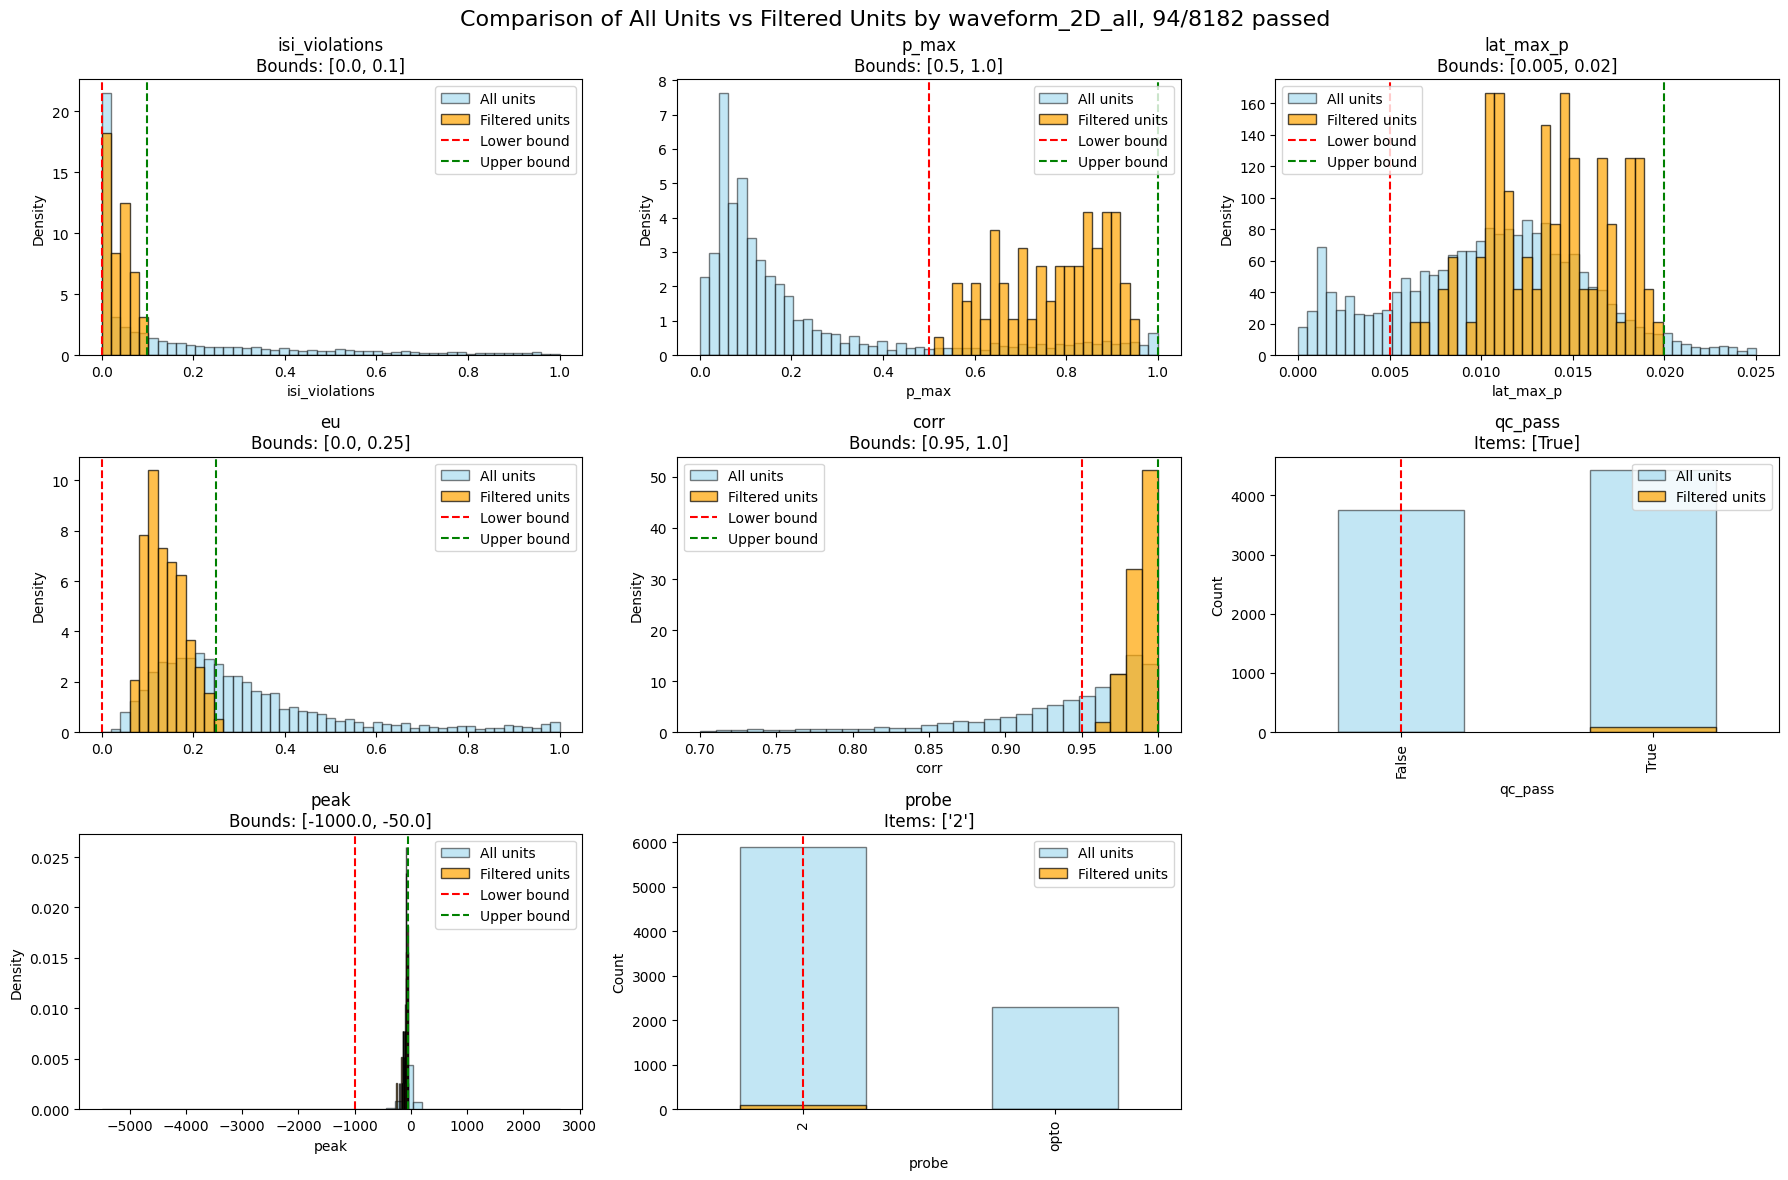

In [210]:
valid_constraints = {col: cfg for col, cfg in constraints.items() if col in combined_tagged_units.columns}
n = len(valid_constraints)

ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 4))
axes = axes.flatten()

for i, (col, cfg) in enumerate(valid_constraints.items()):
    ax = axes[i]
    full_data = combined_tagged_units[col].dropna()
    filtered_data = combined_tagged_units_filtered[col].dropna()

    if "bounds" in cfg:
        lb, ub = np.array(cfg["bounds"], dtype=float)
        bins = 50

        match col:
            case 'isi_violations':
                bins =  np.linspace(0, 1, 50)
            case 'eu':
                bins =  np.linspace(0, 1, 50)
            case 'corr':
                bins =  np.linspace(0.7, 1, 30)
            case 'p_max':
                bins =  np.linspace(0, 1, 50)
            case 'lat_max_p':
                bins =  np.linspace(0, 0.025, 50)
        ax.hist(full_data, bins=bins, color='skyblue', edgecolor='black', alpha=0.5, label='All units', density=True)
        ax.hist(filtered_data, bins=bins, color='orange', edgecolor='black', alpha=0.7, label='Filtered units', density=True)

        ax.set_title(f'{col}\nBounds: [{lb}, {ub}]')
        ax.set_xlabel(col)
        ax.set_ylabel('Density')

        if not np.isnan(lb):
            ax.axvline(lb, color='red', linestyle='--', label='Lower bound')
        if not np.isnan(ub):
            ax.axvline(ub, color='green', linestyle='--', label='Upper bound')
        ax.legend()

    elif "items" in cfg:
        full_counts = combined_tagged_units[col].dropna().astype(str).value_counts()
        filtered_counts = combined_tagged_units_filtered[col].dropna().astype(str).value_counts()

        # Get all unique category labels from both datasets
        all_idx = full_counts.index.union(filtered_counts.index)

        # Reindex both with all categories, fill missing with 0
        full_counts = full_counts.reindex(all_idx, fill_value=0)
        filtered_counts = filtered_counts.reindex(all_idx, fill_value=0)

        # Plot
        full_counts.plot(kind='bar', ax=ax, color='skyblue', alpha=0.5, edgecolor='black', label='All units')
        filtered_counts.plot(kind='bar', ax=ax, color='orange', alpha=0.7, edgecolor='black', label='Filtered units')



        for item in cfg["items"]:
            if str(item) in full_counts.index:
                ax.axvline(x=str(item), color='red', linestyle='--')

        ax.set_title(f'{col}\nItems: {cfg["items"]}')
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.legend()

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f'Comparison of All Units vs Filtered Units by {criteria_name}, {len(combined_tagged_units_filtered)}/{len(combined_tagged_units)} passed', fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(wf_folder, f'Pass_histo_{criteria_name}.pdf'))
# plt.show()


In [211]:
# anti_cvs = '/root/capsule/code/data_management/antidromic_units.csv'
# anti_df = pd.read_csv(anti_cvs)
# data_type = 'curated'

# for i, row in combined_tagged_units_filtered.iterrows():
#     session = row['session']
#     unit = row['unit']
#     session_dir = session_dirs(session)

#     # Get list of all PDFs in opto directory
#     opto_dir = session_dir[f'opto_dir_fig_{data_type}']
#     all_pdfs = os.listdir(opto_dir)
    
#     # Find matching PDF
#     matching_pdfs = [pdf for pdf in all_pdfs if f'unit_{int(unit)}_' in pdf and pdf.endswith('.pdf')]
#     if not matching_pdfs:
#         print(f'No opto pdf found for {session}, {unit}')
#         continue

#     pdf = matching_pdfs[0]
#     pdf_path = os.path.join(opto_dir, pdf)

#     # Copy to general opto folder
#     new_path_opto = os.path.join(opto_folder, f'{session}_{pdf}')
#     shutil.copy(pdf_path, new_path_opto)

#     # Copy to anti_opto_folder if anti_resp is not NaN
#     if pd.notna(row['anti_resp']):
#         new_path_opto = os.path.join(
#             anti_opto_folder,
#             f'{session}_{row["proj"]}_tier_{row["anti_resp"]}_{pdf}'
#         )
#         shutil.copy(pdf_path, new_path_opto)

#         # Check if anti unit exists
#         if anti_df.query("session == @session and unit_id == @unit").empty:
#             print(f'Error: anti unit not found in anti_df for {session}, {unit}')


In [212]:
# grab all tagged units and combine a pdf
data_type = 'curated'
target = 'soma'
opto_folder = os.path.join(wf_folder, 'opto_tagged')
behavior_folder = os.path.join(wf_folder, 'behavior_tagged_response')
anti_opto_folder = os.path.join(wf_folder, 'anti_opto')
anti_behavior_folder = os.path.join(wf_folder, 'anti_behavior')
shutil.rmtree(opto_folder, ignore_errors=True)
shutil.rmtree(behavior_folder, ignore_errors=True)
shutil.rmtree(anti_opto_folder, ignore_errors=True)
shutil.rmtree(anti_behavior_folder, ignore_errors=True)

os.makedirs(name=opto_folder, exist_ok=True)
os.makedirs(name=behavior_folder, exist_ok=True)
os.makedirs(name=anti_opto_folder, exist_ok=True)
os.makedirs(name=anti_behavior_folder, exist_ok=True)

anti_cvs = '/root/capsule/code/data_management/antidromic_units.csv'
anti_df = pd.read_csv(anti_cvs)

for i, row in combined_tagged_units_filtered.iterrows():
    session = row['session']
    unit = row['unit']
    session_dir = session_dirs(session)
    # opto_file
    all_pdfs = os.listdir(session_dir[f'opto_dir_fig_{data_type}'])
    pdf = [pdf for pdf in all_pdfs if f'unit_{int(unit)}_' in pdf and pdf.endswith('.pdf')]
    if len(pdf) == 0:
        print(f'No opto pdf found for {session}, {unit}')
        continue
    else:
        pdf = pdf[0]
    pdf_path = os.path.join(session_dir[f'opto_dir_fig_{data_type}'], pdf)
    # copy to new path
    new_path_opto = os.path.join(opto_folder, f'{session}_{pdf}')
    _ = shutil.copy(pdf_path, new_path_opto)   
    if ~np.isnan(row['anti_resp']):
        new_path_opto = os.path.join(anti_opto_folder, f'{session}_{row["proj"]}_tier_{row["anti_resp"]}_{pdf}')
        _ = shutil.copy(pdf_path, new_path_opto)
        if anti_df.query("session == @session and unit_id == @unit").empty:
            print(f'Error anti unit found for {session}, {unit}')
        elif len(anti_df.query("session == @session and unit_id == @unit")) == 1:
            print(f'Correct anti unit found for {session}, {unit}')

    # selected_sessions.append(session)
    # selected_units.append(unit)
    # all_pdf.append(pdf_path)

    # behavior file: go cue
    if row['in_df']:
        all_pdfs = os.listdir(os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'response'))
        pdf = [pdf for pdf in all_pdfs if f'unit_{int(unit)}_' in pdf and pdf.endswith('.pdf')]
        if len(pdf) == 0:
            print(f'No response pdf found for {session}, {unit}')
            continue
        else:
            pdf = pdf[0]
        pdf_path = os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'response', pdf)
        # copy to new path
        new_path_ephys = os.path.join(behavior_folder, f'{session}_{pdf}')
        _ = shutil.copy(pdf_path, new_path_ephys)

        if ~np.isnan(row['anti_resp']):
            new_path_ephys = os.path.join(anti_behavior_folder, f'{session}_{row["proj"]}_tier_{row["anti_resp"]}_{pdf}')
            _ = shutil.copy(pdf_path, new_path_ephys)


Correct anti unit found for behavior_716325_2024-05-31_10-31-14, 197.0
Correct anti unit found for behavior_717121_2024-06-15_10-00-58, 162.0
Correct anti unit found for behavior_751004_2024-12-20_13-26-11, 263.0
Correct anti unit found for behavior_751769_2025-01-17_11-37-39, 288.0
Correct anti unit found for behavior_751769_2025-01-18_10-15-25, 29.0
Correct anti unit found for behavior_758017_2025-02-04_11-57-38, 5.0
Correct anti unit found for behavior_758017_2025-02-05_11-42-34, 37.0
Correct anti unit found for behavior_758017_2025-02-07_14-11-08, 44.0
Correct anti unit found for behavior_751766_2025-02-13_11-31-21, 24.0
Correct anti unit found for behavior_751766_2025-02-14_11-37-11, 36.0
Correct anti unit found for behavior_751181_2025-02-25_12-12-35, 14.0
Correct anti unit found for behavior_751181_2025-02-26_11-51-19, 273.0
Correct anti unit found for behavior_751181_2025-02-27_11-24-47, 57.0
Correct anti unit found for behavior_754897_2025-03-13_11-20-42, 283.0


In [213]:
# combine_pdf_big(os.path.join(wf_folder, 'opto_tagged'), os.path.join(wf_folder, 'opto_combined.pdf'))
# combine_pdf_big(os.path.join(wf_folder, 'behavior_tagged_response'), os.path.join(wf_folder, 'behavior_combined.pdf'))

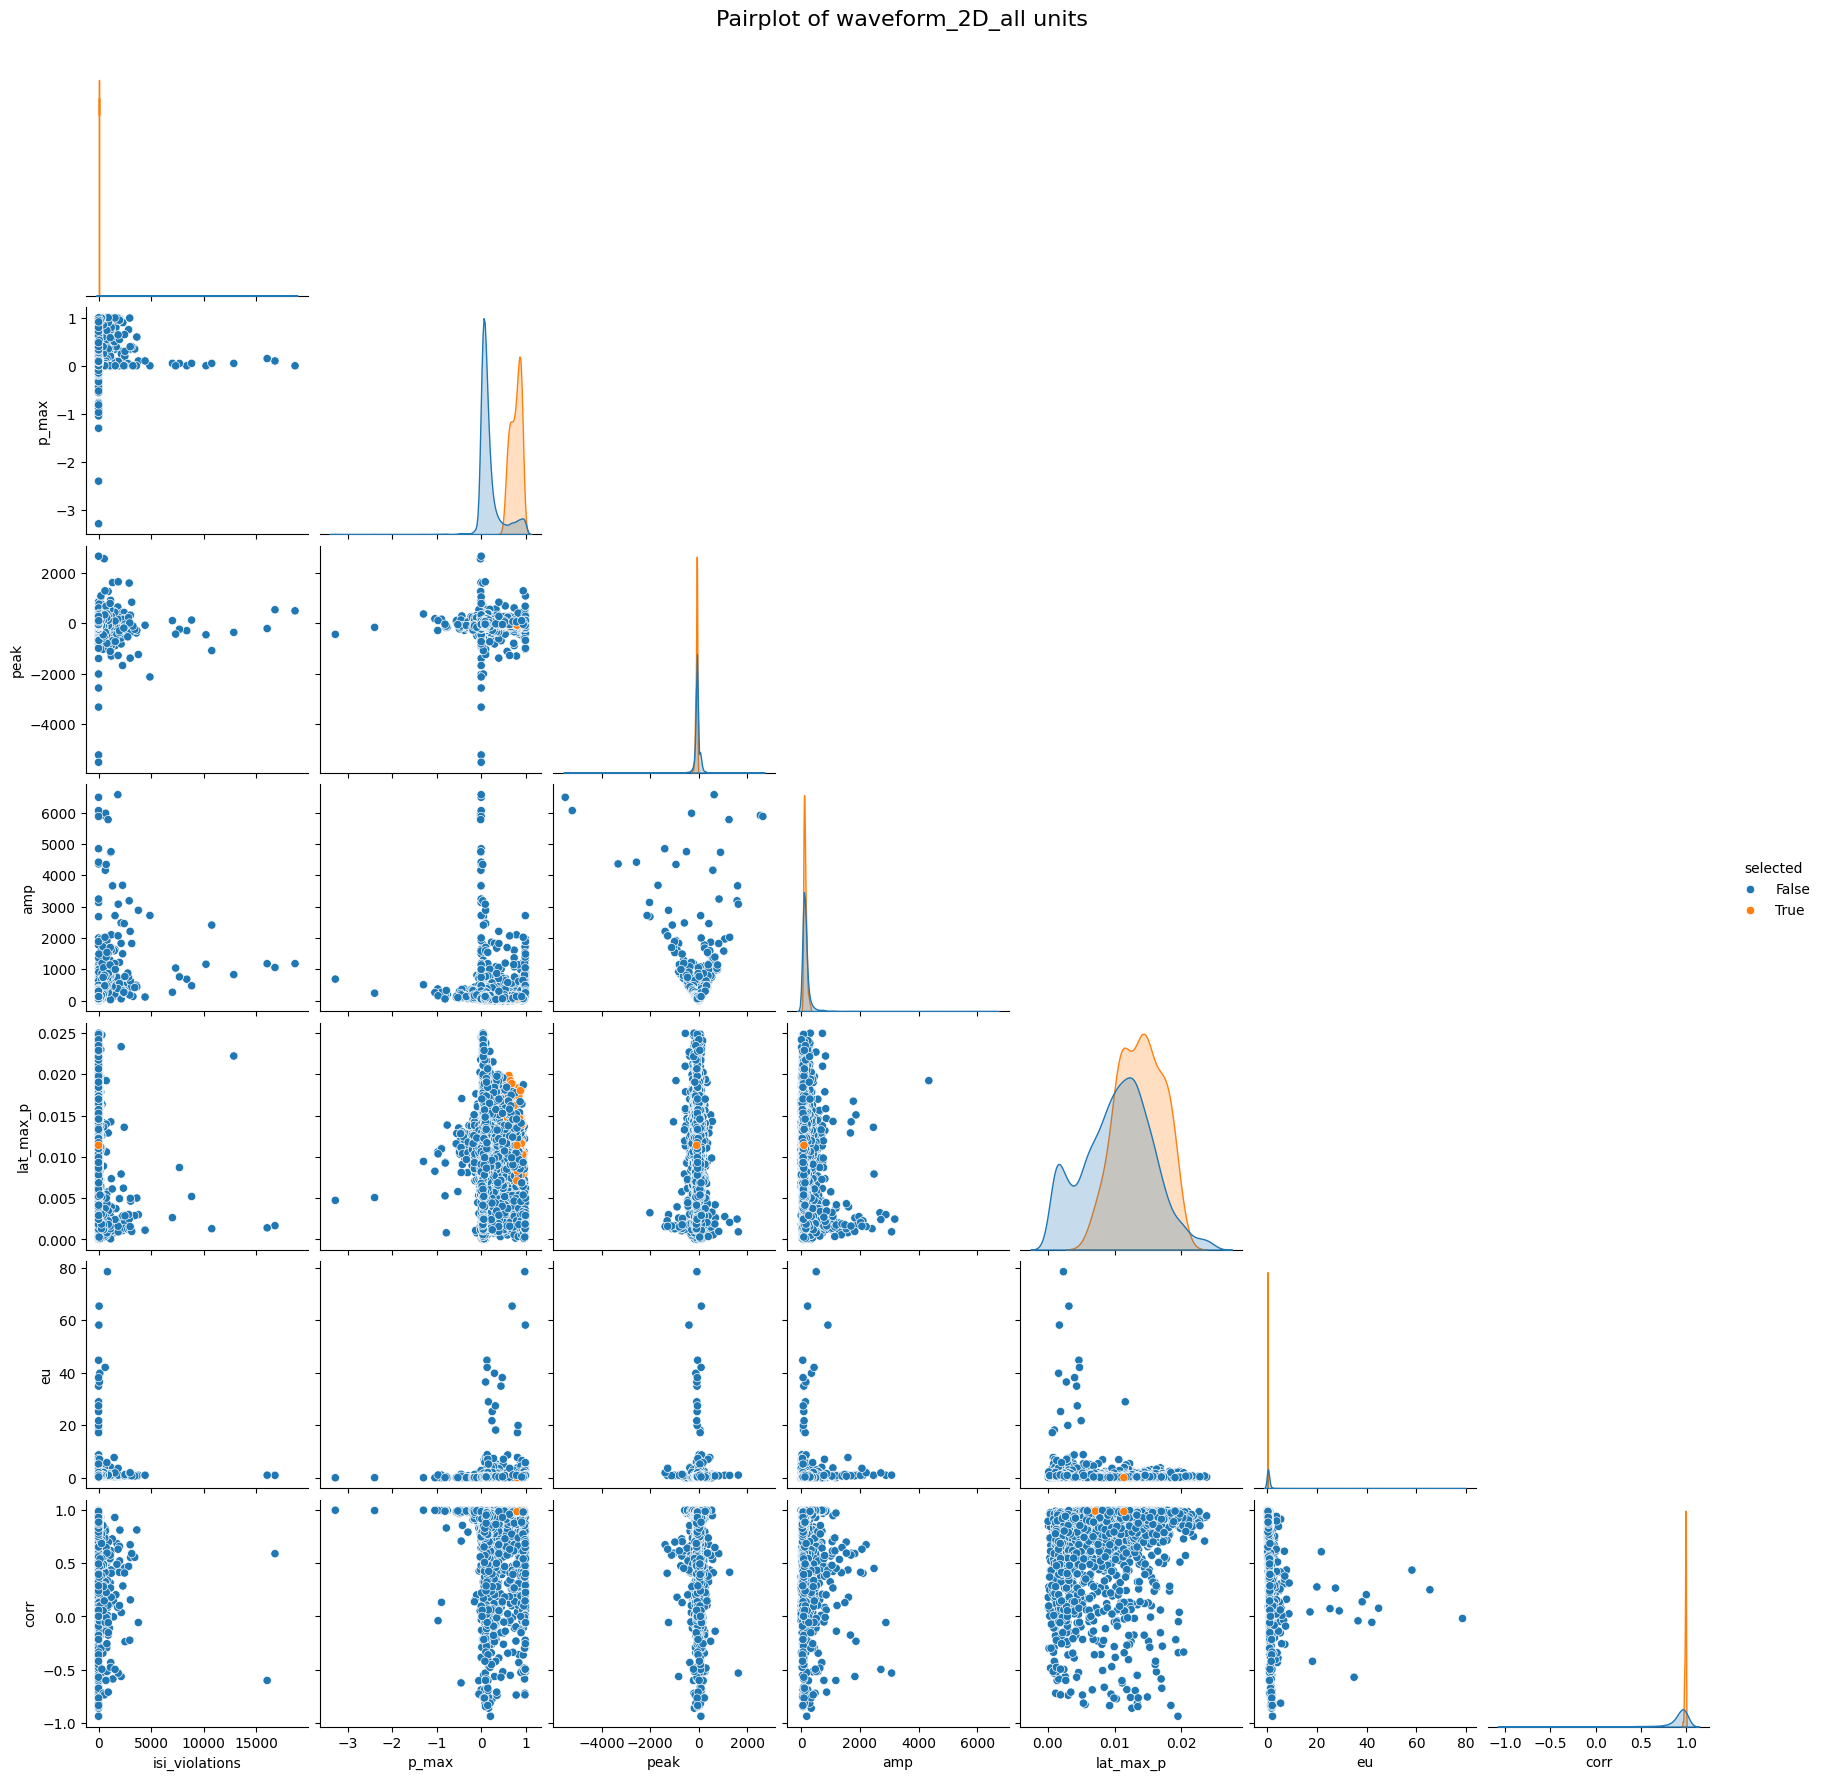

In [214]:
g = sns.pairplot(
        combined_tagged_units[['isi_violations', 'p_max', 'selected', 'peak', 'amp', 'lat_max_p', 'eu', 'corr']],
        hue='selected',
        corner=True,
        diag_kind='auto',
        # plot_kws={'alpha': 0.5, 's': 5}, # 'linewidth': 2, 'facecolor': 'none'},
        diag_kws={'common_norm': False}
    )

# save
g.fig.suptitle(f'Pairplot of {criteria_name} units', y=1.02, fontsize=16)
g.savefig(os.path.join(wf_folder, f'Pass_pairplot_{criteria_name}.pdf'))


In [215]:
# Extract waveform feature
wf_norm = []
wf_2D_norm = []

half_w = []
trough_w = []
pre_half = []
post_half = []

trough_post_ratio_1D = []
trough_pre_ratio_1D = []

post_slope = []
post_space = []
pre_slope = []
pre_space = []

symmetry_inte = []
symmetry_half = []
symmetry_slope = []
symmetry_inte_div = []
symmetry_half_div = []
symmetry_slope_div = []

wf_norm = combined_tagged_units_filtered['wf']/np.abs(combined_tagged_units_filtered['peak'])
wf_2D_norm = combined_tagged_units_filtered['wf_2d']/np.abs(combined_tagged_units_filtered['peak'])
for rows in combined_tagged_units_filtered.iterrows():
    wf = rows[1]['wf']
    peak = rows[1]['peak']
    if peak<0:
        curr_trough_loc = np.argmax(wf[30:])+1
        post_trough = np.max(wf[30:])
        post_trough_ind = np.argmax(wf[30:])+1
        pre_trough = np.max(wf[:30])
        pre_trough_ind = 30 - np.argmax(wf[:30])  
    else:
        curr_trough_loc = np.argmin(wf[30:])+1
        post_trough = np.min(wf[30:])
        post_trough_ind = np.argmin(wf[30:])+1
        pre_trough = np.min(wf[:30])
        pre_trough_ind = 30 - np.argmin(wf[:30])  
    curr_trough_post = post_trough/peak # positive if same sign, negative if opposite sign
    curr_trough_pre = pre_trough/peak # positive if same sign, negative if opposite sign
    curr_trough_loc_slope_post = ((peak - post_trough)/peak)/post_trough_ind # positive if same sign, negative if opposite sign
    curr_trough_loc_inte_post = ((peak - pre_trough)/peak)*post_trough_ind # positive if same sign, negative if opposite sign
    curr_trough_loc_slope_pre = ((peak - pre_trough)/peak)/pre_trough_ind # positive if same sign, negative if opposite sign
    curr_trough_loc_inte_pre = ((peak - post_trough)/peak)*pre_trough_ind # positive if same sign, negative if opposite sign

    curr_symmetry_inte = curr_trough_loc_inte_post - curr_trough_loc_inte_pre  # positive if same sign, negative if opposite sign
    curr_symmetry_slope = curr_trough_loc_slope_post - curr_trough_loc_slope_pre  # positive if same sign, negative if opposite sign
    
    

    # find samples where the waveform crosses the half peak threshold to infer half width
    half_peak = peak / 2
    wf_half_crossings = np.where(np.diff(np.sign(wf - half_peak))!=0)[0]
    if len(wf_half_crossings) < 2:
        post_crossing = 0
        pre_crossing = 0
    else: 
        post_crossing = np.min(wf_half_crossings[wf_half_crossings > 30]) - 30
        pre_crossing = 30 - np.max(wf_half_crossings[wf_half_crossings < 30])

    half_w.append(post_crossing + pre_crossing)  # half width in samples
    trough_w.append(post_trough_ind + pre_trough_ind)  # trough width in samples
    pre_half.append(pre_crossing)
    post_half.append(post_crossing)

    trough_post_ratio_1D.append(curr_trough_post)
    trough_pre_ratio_1D.append(curr_trough_pre)

    post_slope.append(curr_trough_loc_slope_post)
    post_space.append(curr_trough_loc_inte_post)
    pre_slope.append(curr_trough_loc_slope_pre)
    pre_space.append(curr_trough_loc_inte_pre)

    symmetry_inte.append(curr_trough_loc_inte_post - curr_trough_loc_inte_pre)
    symmetry_half.append(post_crossing - pre_crossing)
    symmetry_slope.append(curr_trough_loc_slope_post - curr_trough_loc_slope_pre)

    symmetry_inte_div.append(curr_trough_loc_inte_post/curr_trough_loc_inte_pre)
    symmetry_half_div.append(post_crossing/pre_crossing)
    symmetry_slope_div.append(curr_trough_loc_slope_post/curr_trough_loc_slope_pre)


wf_features = pd.DataFrame({'unit_id': combined_tagged_units_filtered['unit'],
                            'session': combined_tagged_units_filtered['session'],
                            'amp': combined_tagged_units_filtered['amp'],
                            'peak': combined_tagged_units_filtered['peak'],
                            'half_w': half_w,
                            'trough_w': trough_w,
                            'pre_half': pre_half,
                            'post_half': post_half,
                            'trough_post_ratio_1D': trough_post_ratio_1D,
                            'trough_pre_ratio_1D': trough_pre_ratio_1D,
                            'post_slope': post_slope,
                            'post_space': post_space,
                            'pre_slope': pre_slope,
                            'pre_space': pre_space,
                            'symmetry_inte': symmetry_inte,
                            'symmetry_half': symmetry_half,
                            'symmetry_slope': symmetry_slope,
                            'symmetry_inte_div': symmetry_inte_div,
                            'symmetry_half_div': symmetry_half_div,
                            'symmetry_slope_div': symmetry_slope_div,
                            'y_loc': combined_tagged_units_filtered['y_loc'],
                            'probe': combined_tagged_units_filtered['probe'],
                            })
                            


In [216]:
combined_tagged_units_filtered.columns

Index(['session', 'unit', 'qc_pass', 'opto_tagged', 'opto_tagging_pre',
       'opto_tagging_post', 'anti', 'in_df', 'trial_count', 'p_max',
       'lat_max_p', 'isi_violations', 'snr', 'eu', 'corr', 'amp', 'peak', 'wf',
       'wf_aligned', 'wf_2d', 'probe', 'y_loc', 'rec_side', 'top', 'bottom',
       'anti_resp', 'proj', 'x_ccf', 'y_ccf', 'z_ccf'],
      dtype='object')

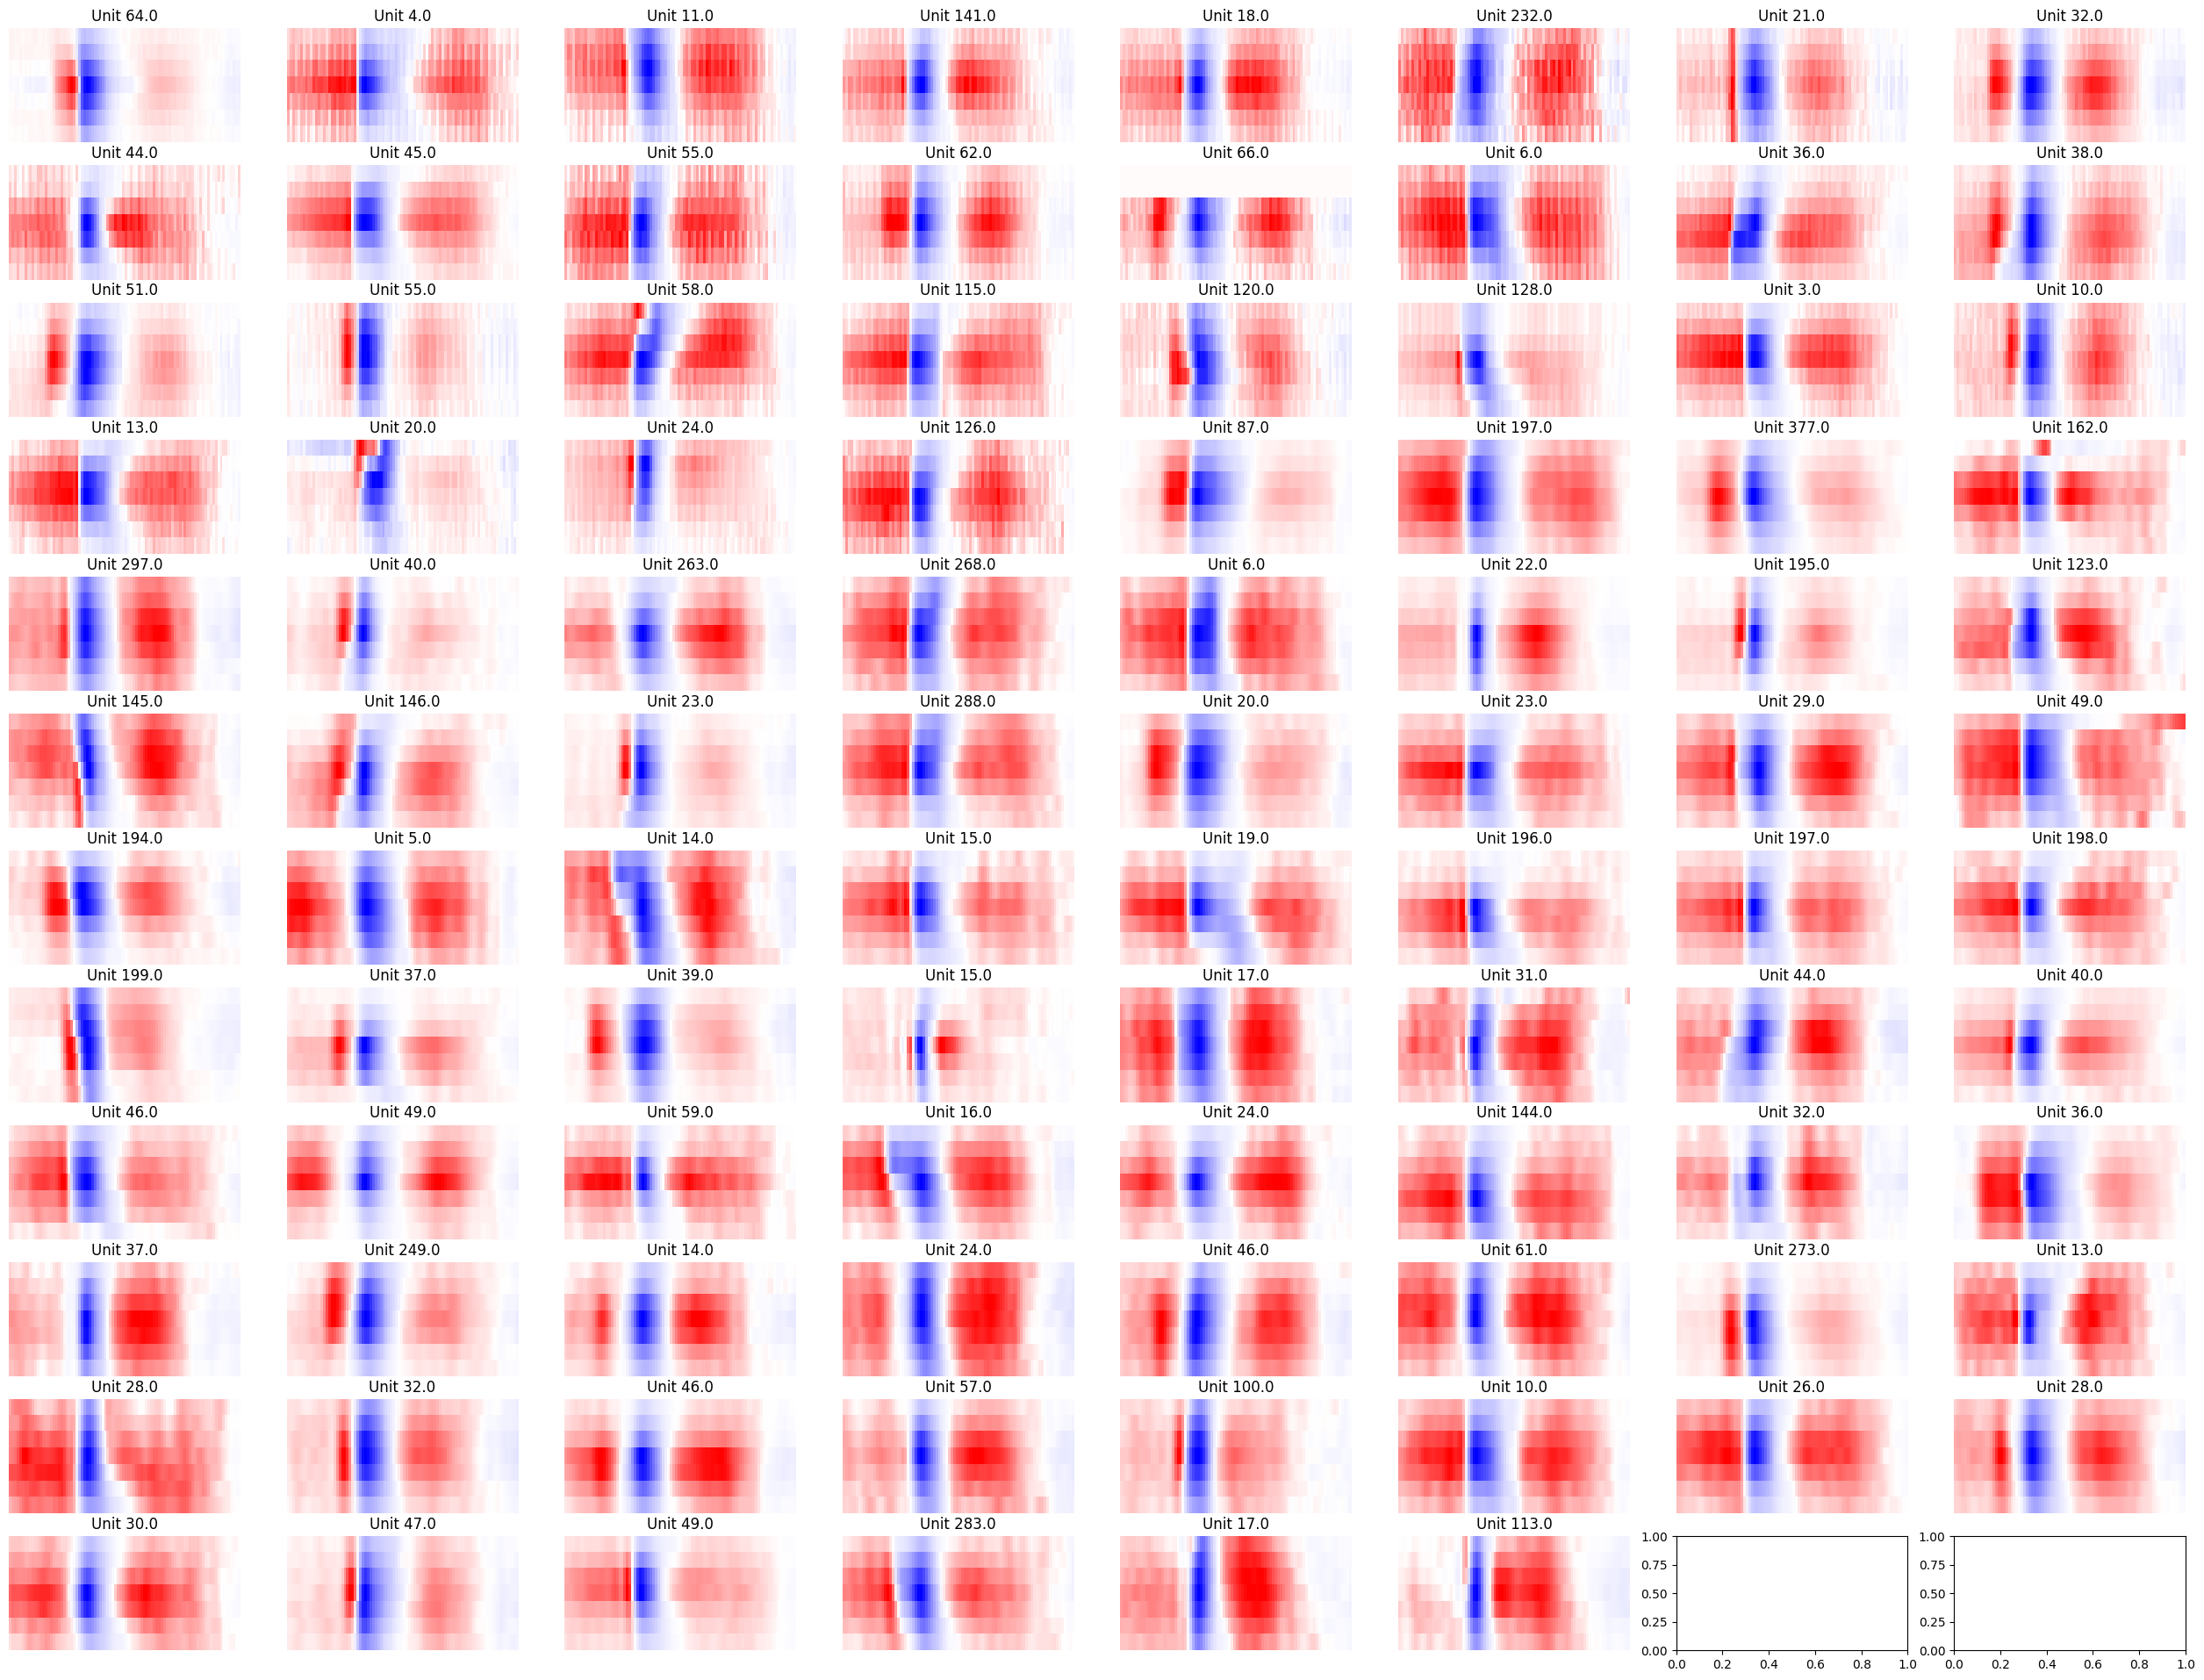

In [217]:
# plot all 2D waveforms in colormap
cmap = LinearSegmentedColormap.from_list('mycmap', ['blue', 'red'], N=256)
ncols = 8
nrows = math.ceil(len(combined_tagged_units_filtered) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 2))
colors = ["blue", "white", "red"]
b_w_r_cmap = LinearSegmentedColormap.from_list("b_w_r", colors)
for i, row in combined_tagged_units_filtered.iterrows():
    ax = axes[i // ncols, i % ncols]
    wf_2D = row['wf_2d']
    # find major column
    left_min = np.min(wf_2D[:, :int(0.5*wf_2D.shape[1])])
    right_min = np.min(wf_2D[:, int(0.5 *wf_2D.shape[1]):])
    if left_min < right_min:
        wf_2D = wf_2D[:, :int(0.5*wf_2D.shape[1])]
    else:
        wf_2D = wf_2D[:, int(0.5 *wf_2D.shape[1]):]
    wf_2D = interpolate_waveform(wf_2D)
    shifted_cmap = shiftedColorMap(b_w_r_cmap, np.nanmin(wf_2D), np.nanmax(wf_2D), 'shifted_b_w_r');
    ax.imshow(wf_2D, cmap=shifted_cmap, aspect='auto', interpolation='none');
    ax.set_title(f"Unit {row['unit']}")
    ax.axis('off')

In [10]:
# compute features 2D
trough_pre_ratio_2D = []
trough_post_ratio_2D = []
trough_pre_time_2D = []
trough_post_time_2D = []
trough_pre_dist_2D = []
trough_post_dist_2D = []
trough_w_2D =[]
peak_fall = []
wf_2D_major = []
peak = []

for ind, rows in combined_tagged_units_filtered.iterrows():
    # if rows['session']=='ecephys_717120_2024-03-06_12-54-27' and rows['unit'] == 66:
    #     print(f'{rows["session"]}, {rows["unit"]}')
    wf_2D = rows['wf_2d']
    curr_peak = rows['peak']
    # find major column
    left_min = np.min(wf_2D[:, :int(0.5*wf_2D.shape[1])])
    right_min = np.min(wf_2D[:, int(0.5 *wf_2D.shape[1]):])
    if left_min < right_min:
        wf_2D = wf_2D[:, :int(0.5*wf_2D.shape[1])]
    else:
        wf_2D = wf_2D[:, int(0.5 *wf_2D.shape[1]):]
    wf_2D = interpolate_waveform(wf_2D)

    # check if there's rows in wf_2D that all equals 0
    if np.any(np.all(wf_2D == 0, axis=1)):
        print(f'0 in wf_2D for {rows["session"]}, {rows["unit"]}')
        # concatenate the features
        trough_w_2D.append(np.nan)
        trough_pre_ratio_2D.append(np.nan)
        trough_post_ratio_2D.append(np.nan)

        trough_pre_time_2D.append(np.nan)
        trough_post_time_2D.append(np.nan)

        trough_pre_dist_2D.append(np.nan)
        trough_post_dist_2D.append(np.nan)

        peak_fall.append(np.nan)
        wf_2D_major.append(wf_2D)
        peak.append(curr_peak)
    else: 
        # for each row of wf_2D, find peak, trough before peak and trough after peak
        peak_ind = [np.argmin(wf_2D[i, :]) for i in range(wf_2D.shape[0])]
        peaks = [wf_2D[i, peak_ind_curr] for i, peak_ind_curr in zip(range(wf_2D.shape[0]), peak_ind)]
        pre_trough_ind = [np.argmax(wf_2D[i, :peak_ind_curr]) for i, peak_ind_curr in zip(range(wf_2D.shape[0]), peak_ind)]
        post_trough_ind = [np.argmax(wf_2D[i, peak_ind_curr:]) + peak_ind_curr for i, peak_ind_curr in zip(range(wf_2D.shape[0]), peak_ind)]
        pre_trough = [wf_2D[i, pre_trough_ind_curr] for i, pre_trough_ind_curr in zip(range(wf_2D.shape[0]), pre_trough_ind)]
        post_trough = [wf_2D[i, post_trough_ind_curr] for i, post_trough_ind_curr in zip(range(wf_2D.shape[0]), post_trough_ind)]
        pre_trough = np.array(pre_trough)
        post_trough = np.array(post_trough)
        pre_trough_ind = np.array(pre_trough_ind)
        post_trough_ind = np.array(post_trough_ind)

        # find max trough pre peak
        curr_max_pre_ind = np.argmax(pre_trough)    
        curr_trough_pre = pre_trough[curr_max_pre_ind]
        curr_trough_pre_time = pre_trough_ind[curr_max_pre_ind]

        curr_max_post_ind = np.argmax(post_trough)
        curr_trough_post = post_trough[curr_max_post_ind]
        curr_trough_post_time = post_trough_ind[curr_max_post_ind]

        curr_trough_half = curr_trough_post_time - curr_trough_pre_time

        # concatenate the features
        trough_w_2D.append(curr_trough_half)
        trough_pre_ratio_2D.append(curr_trough_pre)
        trough_post_ratio_2D.append(curr_trough_post)

        trough_pre_time_2D.append(30 - curr_trough_pre_time)
        trough_post_time_2D.append(curr_trough_post_time - 30)

        trough_pre_dist_2D.append(np.abs(curr_max_pre_ind-3))
        trough_post_dist_2D.append(np.abs(curr_max_post_ind-3))

        peak_fall.append((peaks[0]+peaks[-1])/(2*peaks[3]))
        wf_2D_major.append(wf_2D)
        peak.append(curr_peak)

features_2D = pd.DataFrame({'unit_id': combined_tagged_units_filtered['unit'],
                            'trough_pre_dist_2D': trough_pre_dist_2D,
                            'trough_post_dist_2D': trough_post_dist_2D,
                            'trough_pre_ratio_2D': trough_pre_ratio_2D/peaks[3],
                            'trough_post_ratio_2D': trough_post_ratio_2D/peaks[3],
                            'trough_w_2D': trough_w_2D,
                            'trough_pre_time_2D': trough_pre_time_2D,
                            'trough_post_time_2D': trough_post_time_2D,
                            'peak_fall': peak_fall,
                            'session': combined_tagged_units_filtered['session'],
                            'unit': combined_tagged_units_filtered['unit'],
                            'wf_2D': wf_2D_major,
                            'peak': peak,
                            })


0 in wf_2D for ecephys_717120_2024-03-06_12-54-27, 66.0


In [9]:
#save in pkl
wf_2D_file = os.path.join(wf_folder, 'wf_2D_features.pkl')
with open(wf_2D_file, 'wb') as f:
    pickle.dump(features_2D, f)

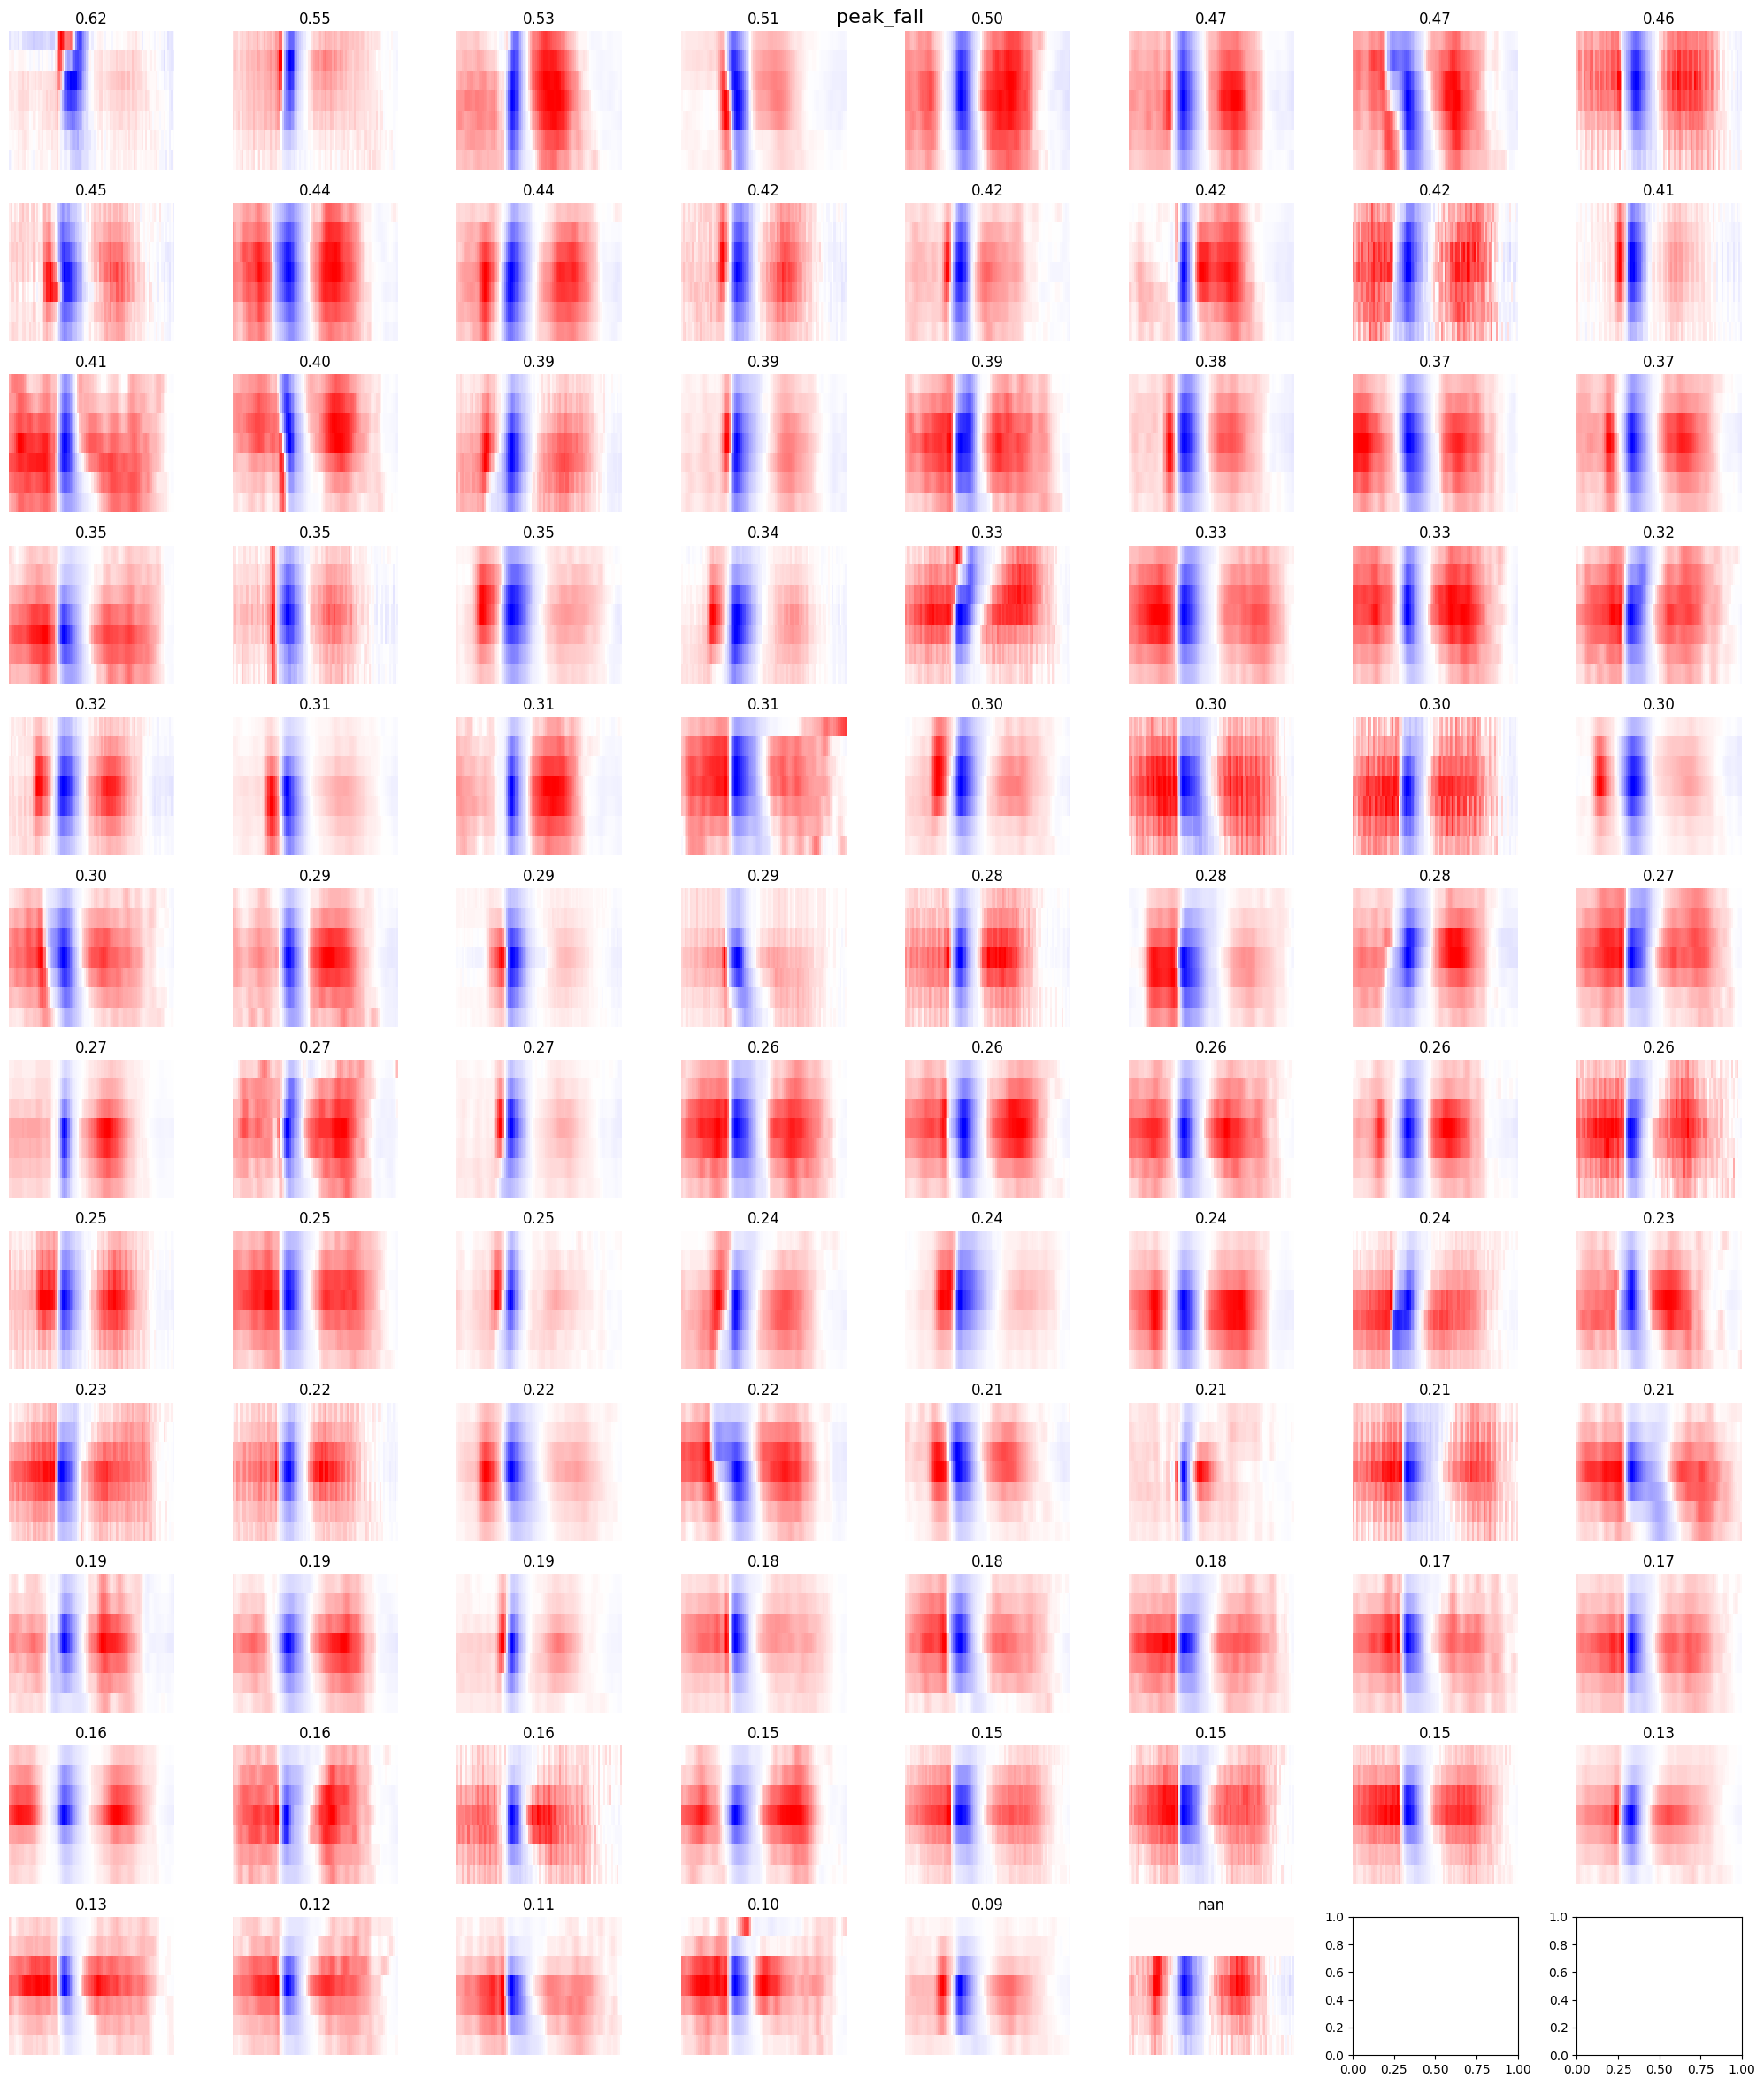

In [219]:
ncols = 8
nrows = int(np.ceil(len(combined_tagged_units_filtered) / ncols))
features = ['trough_pre_dist_2D', 'trough_post_dist_2D', 'trough_post_ratio_2D', 'trough_pre_ratio_2D', 
            'trough_w_2D', 'trough_pre_time_2D', 'trough_post_time_2D', 'peak_fall']
features = ['peak_fall']
for feature in features:
    if feature not in features_2D.columns:
        continue
    focus = features_2D[feature].values
    resorted = features_2D.sort_values(by=feature, ascending=False).reset_index(drop=True)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 2*nrows))
    for i, row in resorted.iterrows():
        ax = axes[i // ncols, i % ncols]
        wf_2D = row['wf']
        shifted_cmap = shiftedColorMap(b_w_r_cmap, np.nanmin(wf_2D), np.nanmax(wf_2D), 'shifted_b_w_r');
        ax.imshow(wf_2D, cmap=shifted_cmap, aspect='auto', interpolation='none');
        ax.axis('off')
        ax.set_title(f'{row[feature]:.2f}')
    plt.suptitle(feature, fontsize=16)
    plt.tight_layout()
    fig.savefig(fname=os.path.join(wf_folder, f'{feature}_wf.png'), dpi=300, bbox_inches='tight')

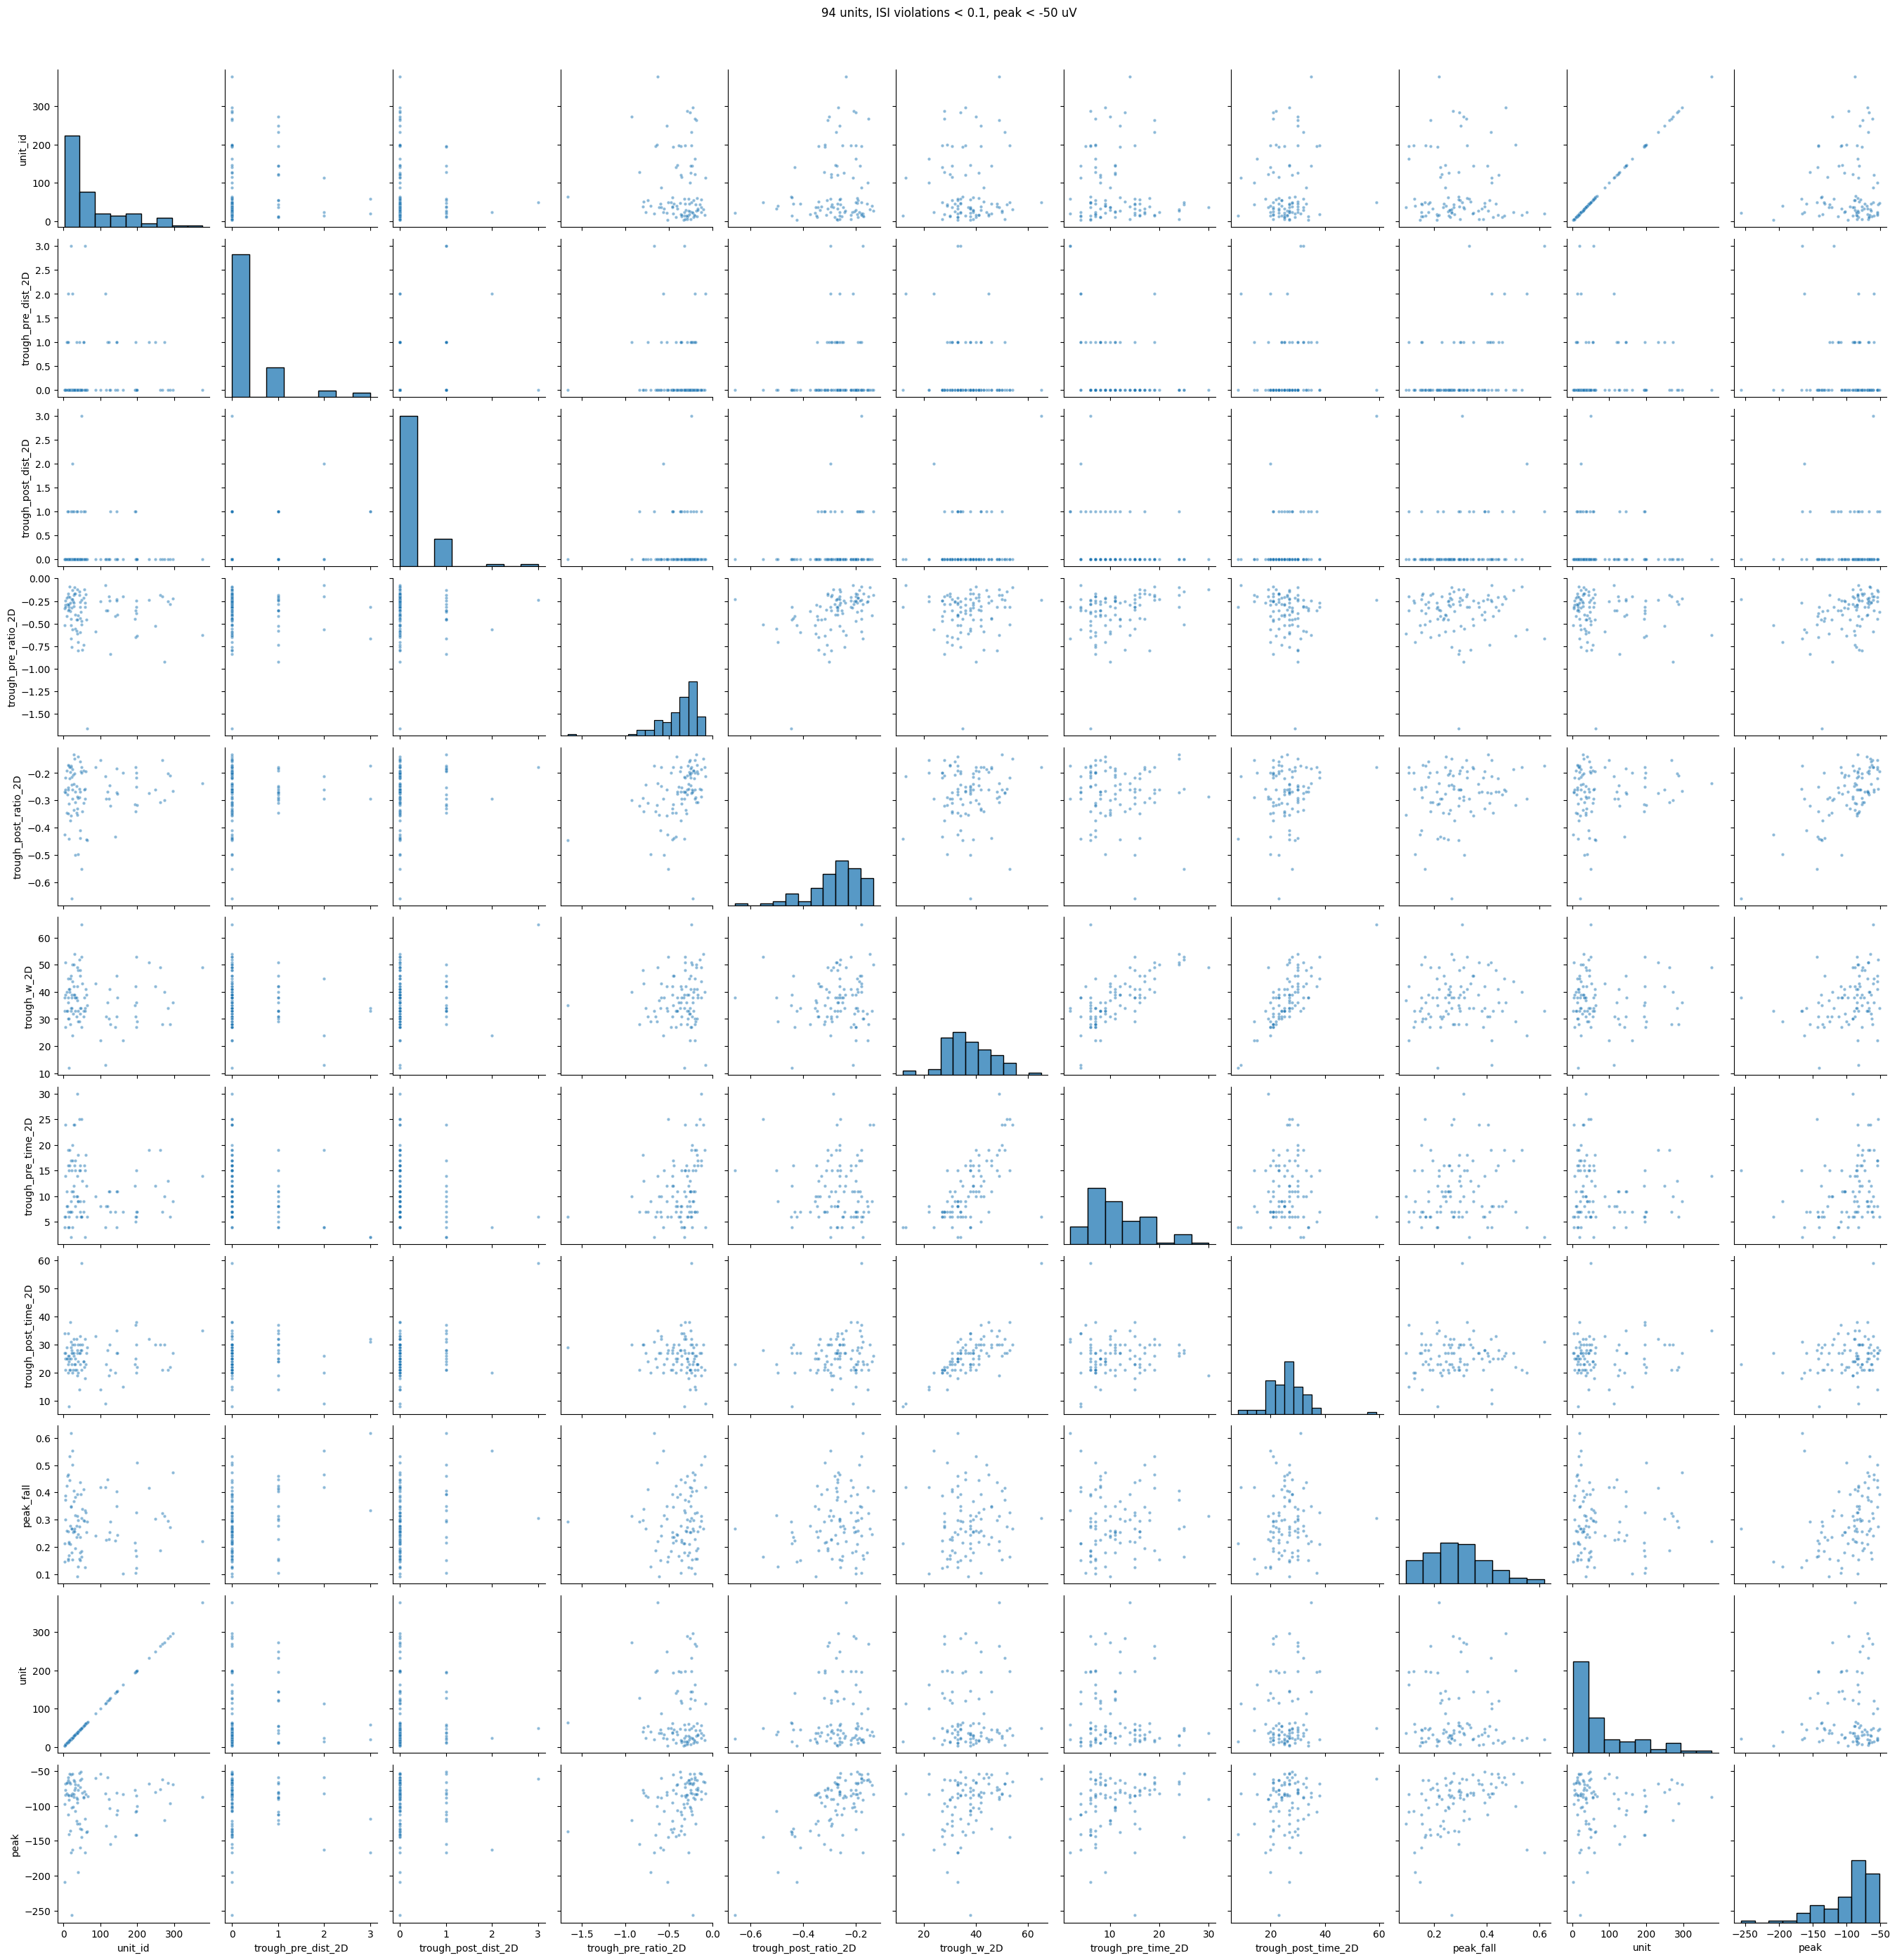

In [220]:
columns = features_2D.columns.tolist()
columns.remove('wf')
g = sns.pairplot(features_2D[columns], corner=False, 
             plot_kws={'alpha': 0.5, 's': 10},
            #  hue='probe'
             )
# save figure
title = f"{len(features_2D)} units, ISI violations < {constraints['isi_violations']['bounds'][1]}, peak < {constraints['peak']['bounds'][1]} uV"
g.fig.suptitle(title, y=1.02)
g.savefig(os.path.join(wf_folder, f'Wf_features_pairplot_{criteria_name}.png'), dpi=300)

In [221]:
# grab all tagged units and combine spike waveforms
data_type = 'curated'
target = 'soma'
selected_sessions = []
selected_units = []
all_pdf = []
curr_session = None

all_peaks = features_2D['peak'].tolist()
all_wfs = features_2D['wf'].tolist()
all_wfs = [np.reshape(curr_wf/curr_peak, (-1, 1)) for curr_wf, curr_peak in zip(all_wfs, all_peaks)]

Text(0.5, 1.0, 'All waveforms')

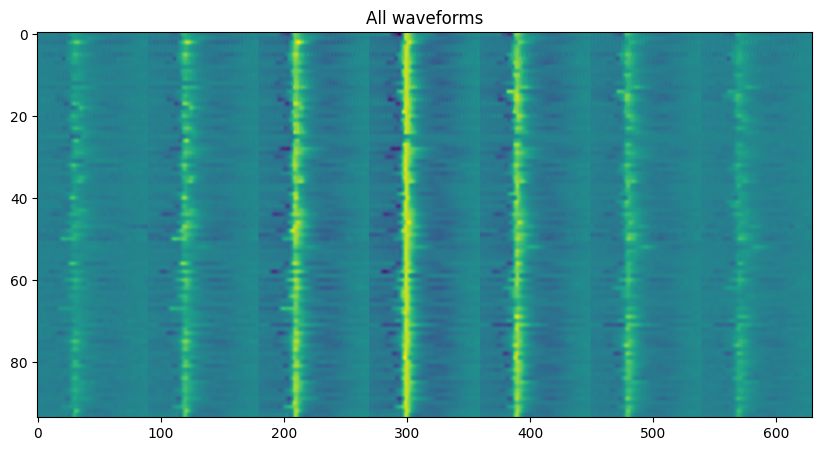

In [222]:
all_wfs = np.array(all_wfs)
baseline = np.mean(all_wfs[:, :5], axis=1, keepdims=True) 
peaks = np.array(all_peaks).reshape(-1, 1) 

# all_wfs_nl = (all_wfs - baseline) / (peaks - baseline)
all_wfs_nl = all_wfs


fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(all_wfs_nl, aspect='auto', cmap='viridis')
ax.set_title('All waveforms')

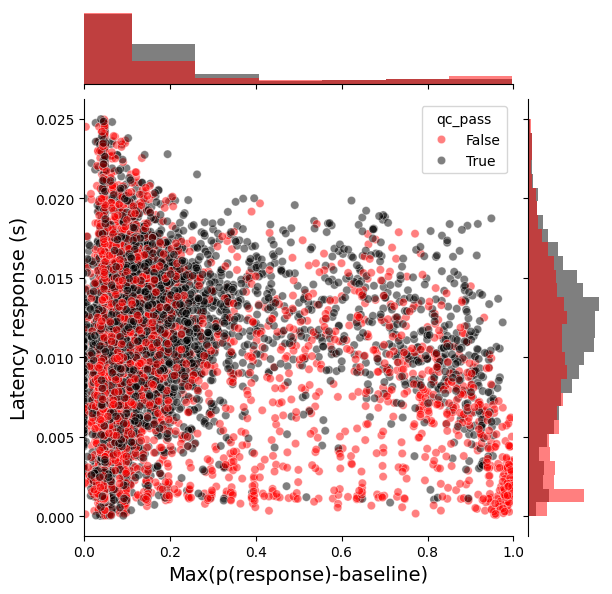

In [223]:
# Define color palette for groups
palette = {True: "k", False: "red"}

# Create JointGrid
g = sns.JointGrid(data=combined_tagged_units, x='p_max', y='lat_max_p', hue='qc_pass', palette=palette)

# Add scatter plot in the center
g.plot_joint(sns.scatterplot, alpha=0.5)
g.ax_joint.set_xlim(0, 1)
g.ax_joint.set_xlabel('Max(p(response)-baseline)', fontsize=14)
g.ax_joint.set_ylabel('Latency response (s)', fontsize=14)

# Add histograms manually for each group
p_max_bins = np.linspace(combined_tagged_units['p_max'].min(), combined_tagged_units['p_max'].max(), 30)
lat_max_p_bins = np.linspace(combined_tagged_units['lat_max_p'].min(), combined_tagged_units['lat_max_p'].max(), 30)
for qc_val, color in palette.items():
    subset = combined_tagged_units[combined_tagged_units['qc_pass'] == qc_val]
    
    # Horizontal histogram for x-axis (default orientation)
    sns.histplot(subset['p_max'], ax=g.ax_marg_x, bins=p_max_bins, color=color, alpha=0.5, edgecolor='none')

    # **VERTICAL histogram for y-axis** using orientation="horizontal"
    sns.histplot(y=subset['lat_max_p'], ax=g.ax_marg_y, bins=lat_max_p_bins, color=color, alpha=0.5, edgecolor='none')


# Show plot
plt.show()


In [224]:
# pca for waveform
# Perform PCA on the waveforms
# amp_thresh = -50
# wf_mat = zscore(all_wfs_nl[np.array(all_peaks)<amp_thresh], axis=0, nan_policy='omit')  # z-score normalize the waveforms
# wf_mat = np.delete(wf_mat, 30, axis=1)
# plt.imshow(wf_mat, aspect='auto', cmap='viridis')
# plt.colorbar(label='Normalized Amplitude')
all_wfs_nl_clean = np.squeeze(all_wfs_nl)


In [225]:
pca = PCA(n_components=12)
pc_time = np.arange(90*7)/30000 * 1000  # assuming 90 samples in the waveform
pca_result = pca.fit_transform(all_wfs_nl_clean)
explained_variance = pca.explained_variance_ratio_
coeff = pca.components_
mean = pca.mean_
all_wfs_pc = pca.inverse_transform(pca_result)

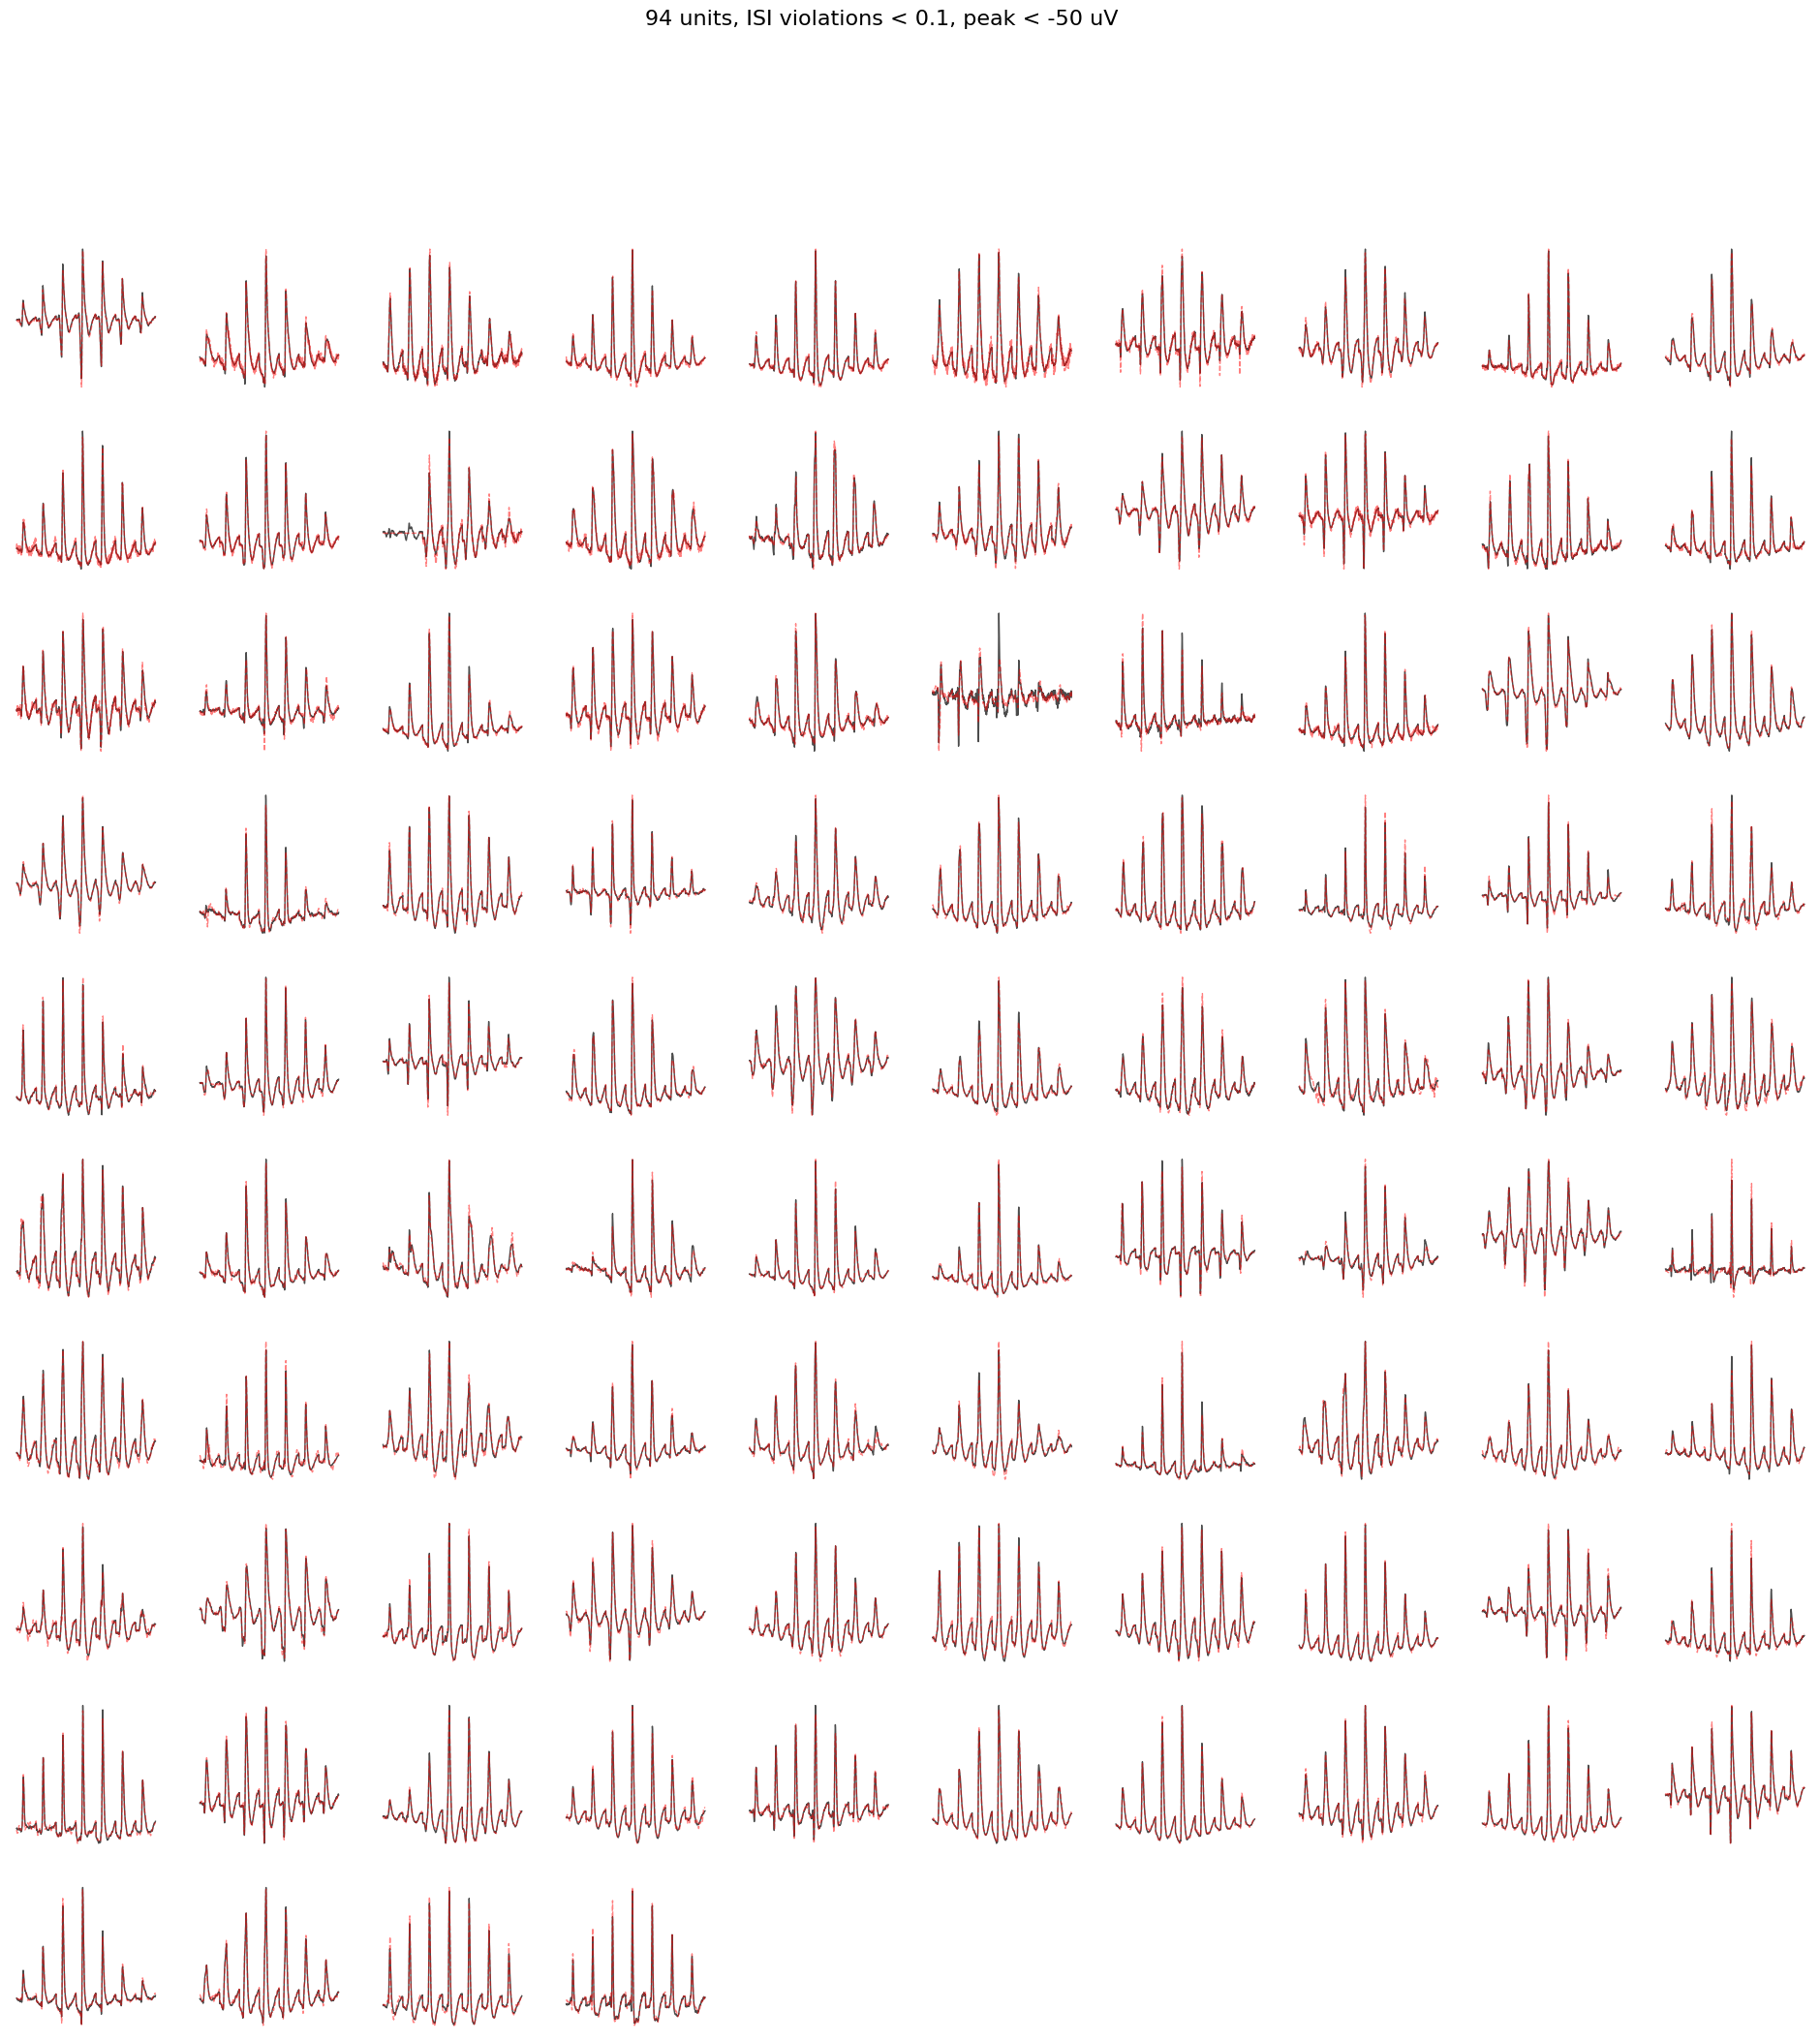

In [226]:
fig = plt.figure(figsize=(24, 24))
gs = gridspec.GridSpec(int(np.ceil(np.sqrt(len(all_wfs_nl_clean)))), int(np.ceil(np.sqrt(len(all_wfs_nl_clean)))), figure=fig)
for i in range(len(all_wfs_nl_clean)):
    ax = fig.add_subplot(gs[i])
    plt.plot(pc_time, all_wfs_pc[i], alpha=0.7, color='k', linewidth=1);
    plt.plot(pc_time, all_wfs_nl_clean[i], color='r', alpha=0.5, linestyle='--', linewidth=1)
    # turn off the axis
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)    
title = f"{len(all_wfs_nl_clean)} units, ISI violations < {constraints['isi_violations']['bounds'][1]}, peak < {constraints['peak']['bounds'][1]} uV"
plt.suptitle(title, fontsize=16)
plt.savefig(fname=os.path.join(wf_folder, f'All-wf_{criteria_name}.pdf'))


Explained variance ratios: [0.24307418 0.23819652 0.11643033 0.07808274 0.05929901 0.04665515
 0.03114341 0.02566812 0.02081698 0.0180807  0.01544065 0.01134124]


Text(0.5, 1.0, 'Explained Variance by PCA Components')

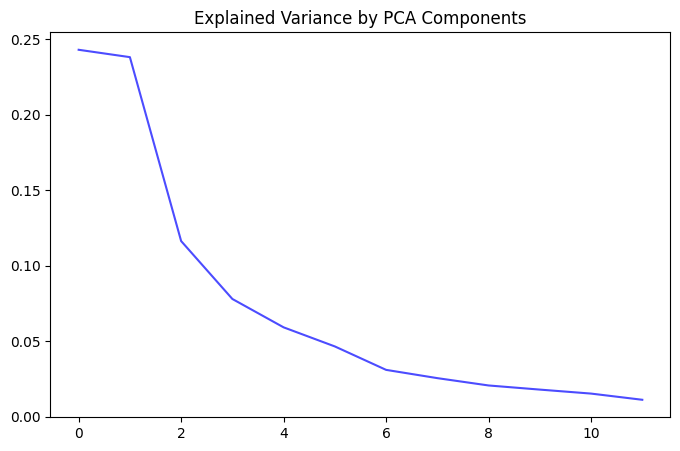

In [227]:
# perform PCA
wf_mat = all_wfs_nl_clean.copy()
# wf_mat = wf_mat[:, 2:-2]
# wf_mat = zscore(all_wfs_nl_clean, axis=0)  # z-score normalize the waveforms
# wf_mat = np.delete(wf_mat, 20, axis=1)  # remove the peak sample to avoid bias in PCA
pca = PCA(n_components=12)  # we can choose the number of components we want
pca_result = pca.fit_transform(wf_mat)
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance ratios: {explained_variance}')
# Plot the explained variance
plt.figure(figsize=(8, 5))
plt.plot(explained_variance, alpha=0.7, color='blue')
plt.title('Explained Variance by PCA Components')

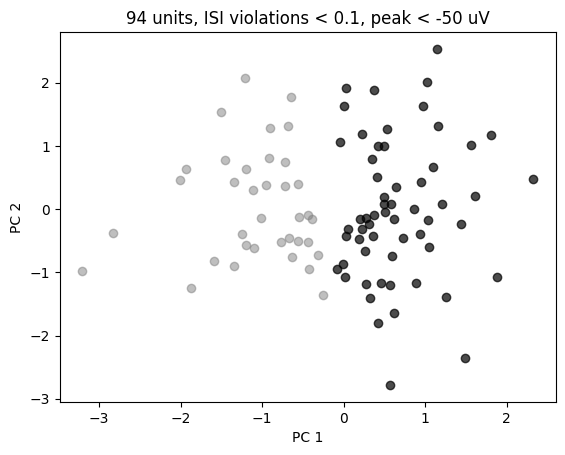

In [228]:
# score = 0.2*pca_result[:, 0] + pca_result[:, 1]
# score = pca_result[:, 0]
score = pca_result[:, 0]
# score = pca_result[:, 0] + pca_result[:, 2]
filter = score > -0.25
pc1 = 0
pc2 = 1
plt.scatter(pca_result[filter, pc1], pca_result[filter, pc2], c = 'k', alpha=0.7)
plt.scatter(pca_result[~filter, pc1], pca_result[~filter, pc2], c = 'gray', alpha=0.5)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
title = f"{len(all_wfs_nl_clean)} units, ISI violations < {constraints['isi_violations']['bounds'][1]}, peak < {constraints['peak']['bounds'][1]} uV"
plt.title(title)
plt.savefig(fname=os.path.join(wf_folder, f'pca_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')

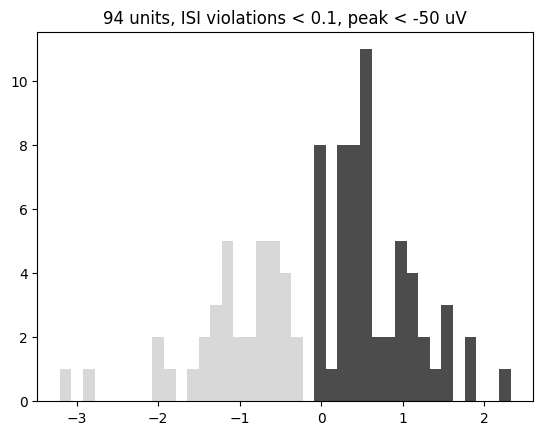

In [229]:
bins = np.linspace(np.min(score), np.max(score), 40)
plt.hist(score[filter], bins=bins, color='k', alpha=0.7);
plt.hist(score[~filter], bins=bins, color='gray', alpha=0.3);
title = f"{len(all_wfs_nl_clean)} units, ISI violations < {constraints['isi_violations']['bounds'][1]}, peak < {constraints['peak']['bounds'][1]} uV"
plt.title(title)
plt.savefig(fname=os.path.join(wf_folder, f'Projection_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')

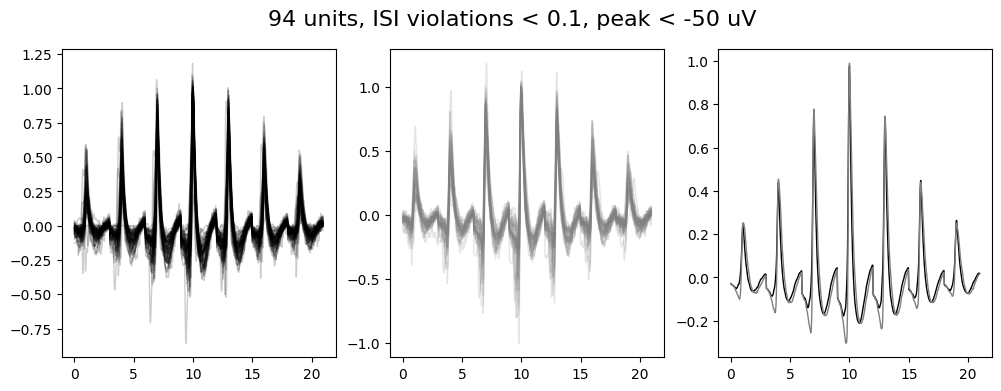

In [230]:
fig = plt.figure(figsize=(12, 4))
wf_time = np.arange(90*7)/30000 * 1000  # assuming 90 samples in the waveform
plt.subplot(1, 3, 1)
plt.plot(wf_time, all_wfs_nl_clean[filter].T, alpha=0.2, linewidth=1, color='k');
plt.subplot(1, 3, 2)
plt.plot(wf_time, all_wfs_nl_clean[~filter].T, alpha=0.2, linewidth=1, color=[0.5, 0.5, 0.5]);  # plot the ones with higher pca values in black
plt.subplot(1, 3, 3)
plt.plot(wf_time, np.mean(all_wfs_nl_clean[filter], axis=0), linewidth=1, color='k');  # plot the ones with higher pca values in black
plt.plot(wf_time, np.mean(all_wfs_nl_clean[~filter], axis=0), linewidth=1, color=[0.5, 0.5, 0.5]);
title = f"{len(all_wfs_nl_clean)} units, ISI violations < {constraints['isi_violations']['bounds'][1]}, peak < {constraints['peak']['bounds'][1]} uV"
plt.suptitle(title, fontsize=16)
plt.savefig(fname=os.path.join(wf_folder, f'Clusters_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')

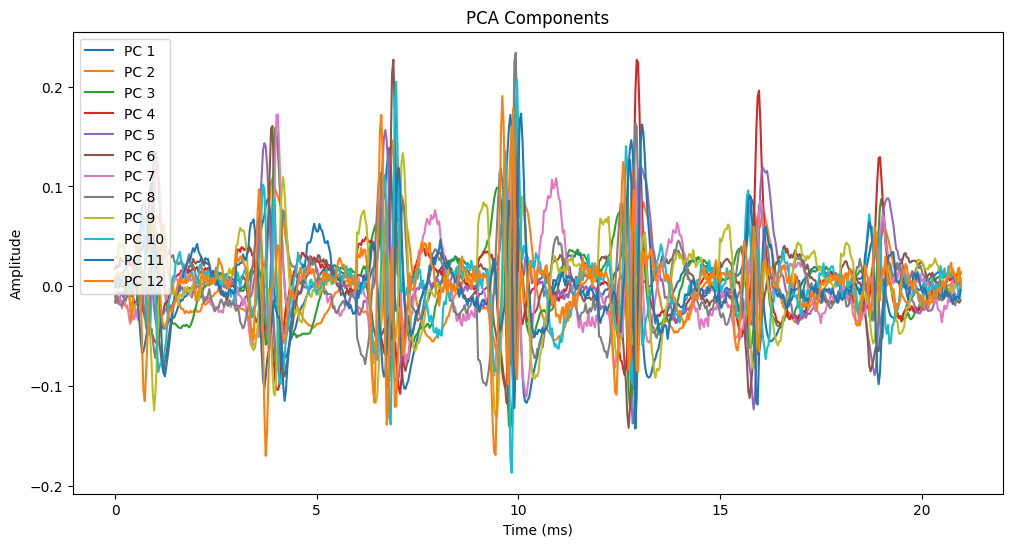

In [231]:
# plot coeff of PCA 
fig, ax = plt.subplots(figsize=(12, 6))
for i in range(pca.components_.shape[0]):
    ax.plot(wf_time, pca.components_[i], label=f'PC {i+1}')
    ax.set_title('PCA Components')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude')
ax.legend()
# save the PCA results


94

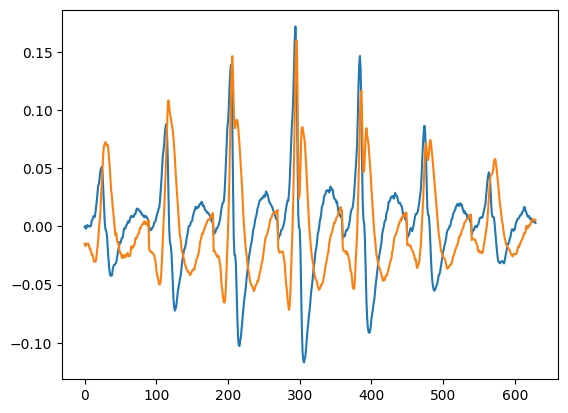

In [232]:
plt.plot(pca.components_[0])
plt.plot(pca.components_[1])
len(score)

In [233]:
# save waveform features
features_2D['score'] = score
features_2D['pc1'] = pca_result[:, 0]
features_2D['pc2'] = pca_result[:, 1]
features_2D.to_csv(os.path.join(wf_folder, 'wf_features_2D.csv'), index=False)

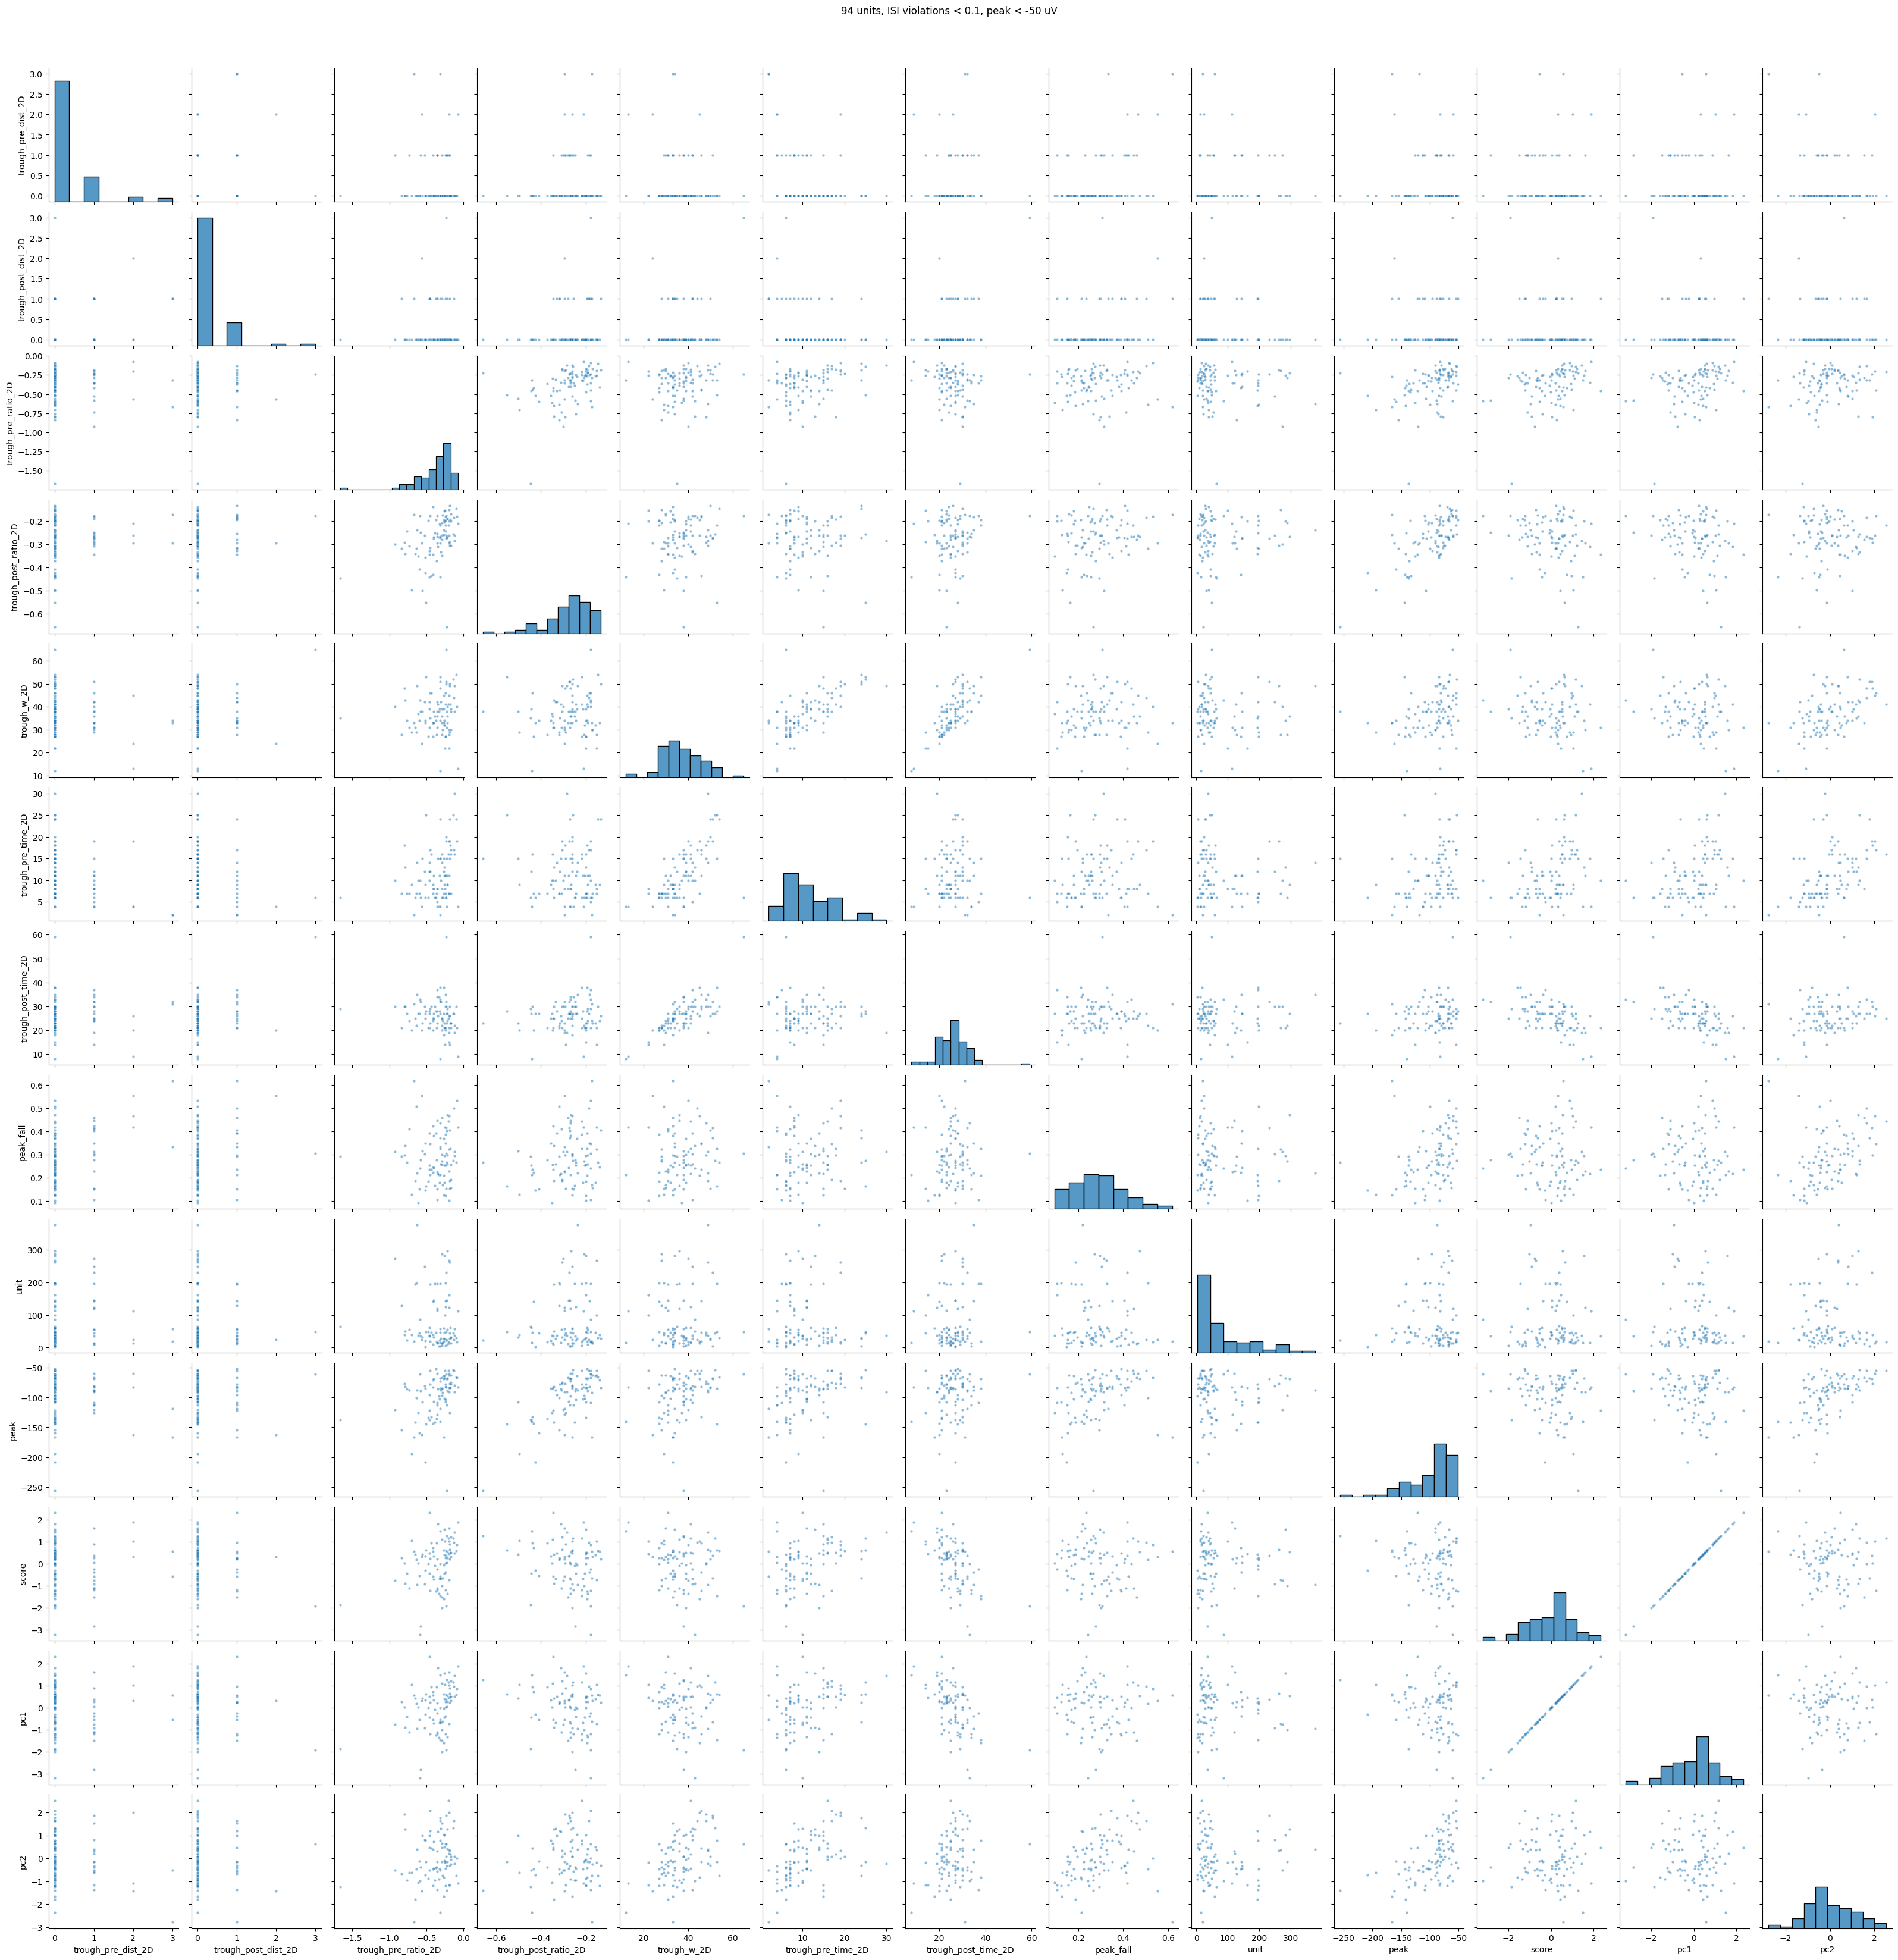

In [234]:
feature = features_2D.drop(columns=['session', 'unit_id', 'wf'])
g = sns.pairplot(feature, corner=False, 
             plot_kws={'alpha': 0.5, 's': 10},
            #  hue='probe'
             )
# save figure
title = f"{len(features_2D)} units, ISI violations < {constraints['isi_violations']['bounds'][1]}, peak < {constraints['peak']['bounds'][1]} uV"
g.fig.suptitle(title, y=1.02)
g.savefig(os.path.join(wf_folder, f'Wf_features_pairplot_{criteria_name}_all.png'), dpi=300)

In [235]:
feature = wf_features[['score', 'trough_post_ratio_1D', 'trough_pre_ratio_1D', 'half_w', 'trough_w', 'pre_slope']].copy()
g = sns.pairplot(feature, corner=False)

KeyError: "['score'] not in index"

<Figure size 800x600 with 0 Axes>

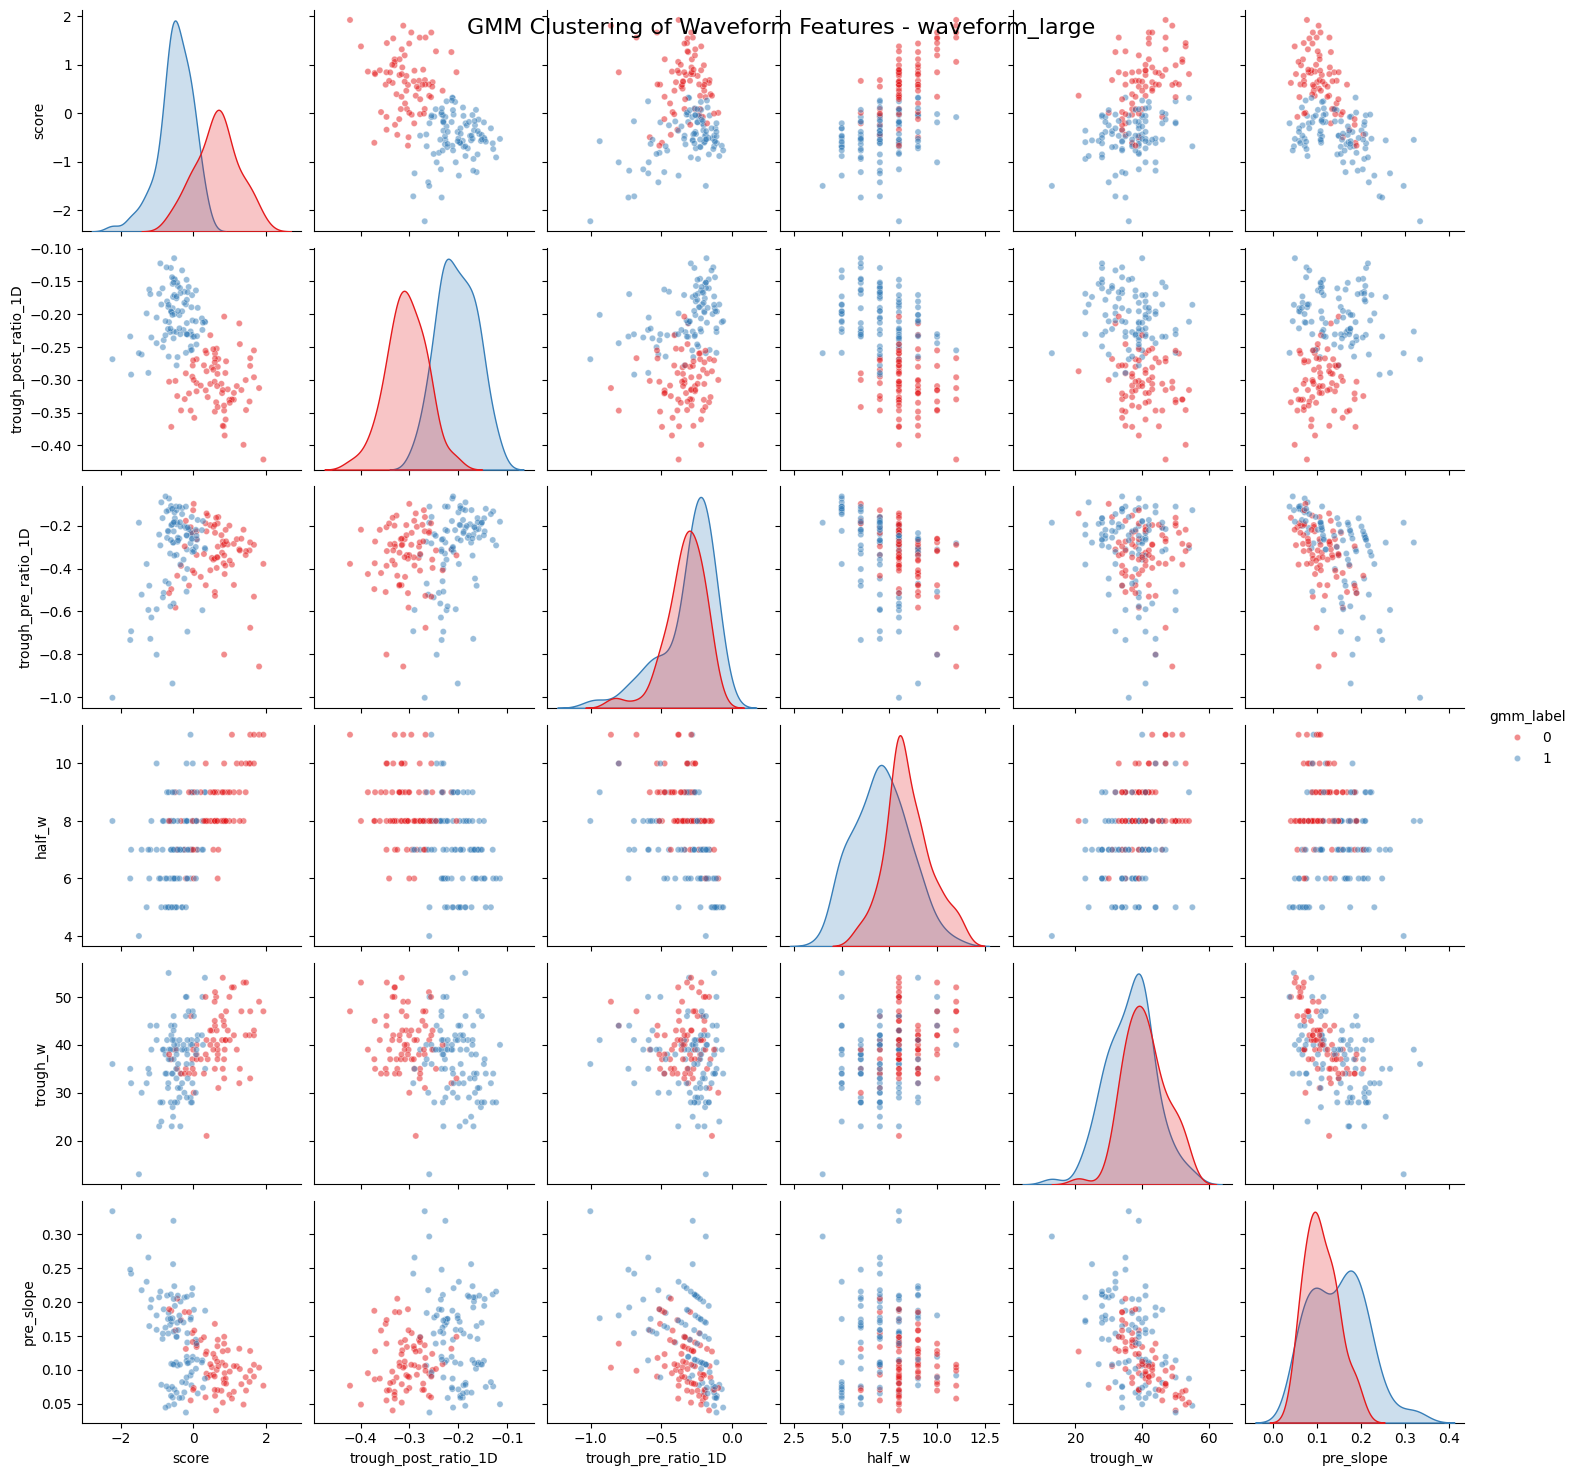

In [ ]:
# perform GMM clustering using features from wf_features
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2, random_state=4)
feature_list = ['score', 'trough_post_ratio_1D']
zscore_feature = zscore(feature[feature_list], axis=0, nan_policy='omit')
gmm.fit(zscore_feature)
feature['gmm_label'] = gmm.predict(zscore_feature)
# plot the GMM clusters
plt.figure(figsize=(8, 6))
g = sns.pairplot(data=feature, hue='gmm_label', vars=['score', 'trough_post_ratio_1D', 'trough_pre_ratio_1D', 'half_w', 'trough_w', 'pre_slope'], palette='Set1', plot_kws={'alpha': 0.5, 's': 20})
plt.xlabel('Score')
plt.ylabel('Trough Post Ratio')
plt.suptitle(f'GMM Clustering of Waveform Features - {criteria_name}', fontsize=16)
# save the GMM model
plt.savefig(os.path.join(wf_folder, f'GMM_clustering_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')
# save feature with gmm cluestering applied
wf_features['gmm_label'] = feature['gmm_label']
wf_features['gmm_conf'] = np.max(gmm.predict_proba(zscore_feature), axis = 1)
wf_features.to_csv(os.path.join(wf_folder, 'wf_features.csv'), index=False)


<Figure size 800x600 with 0 Axes>

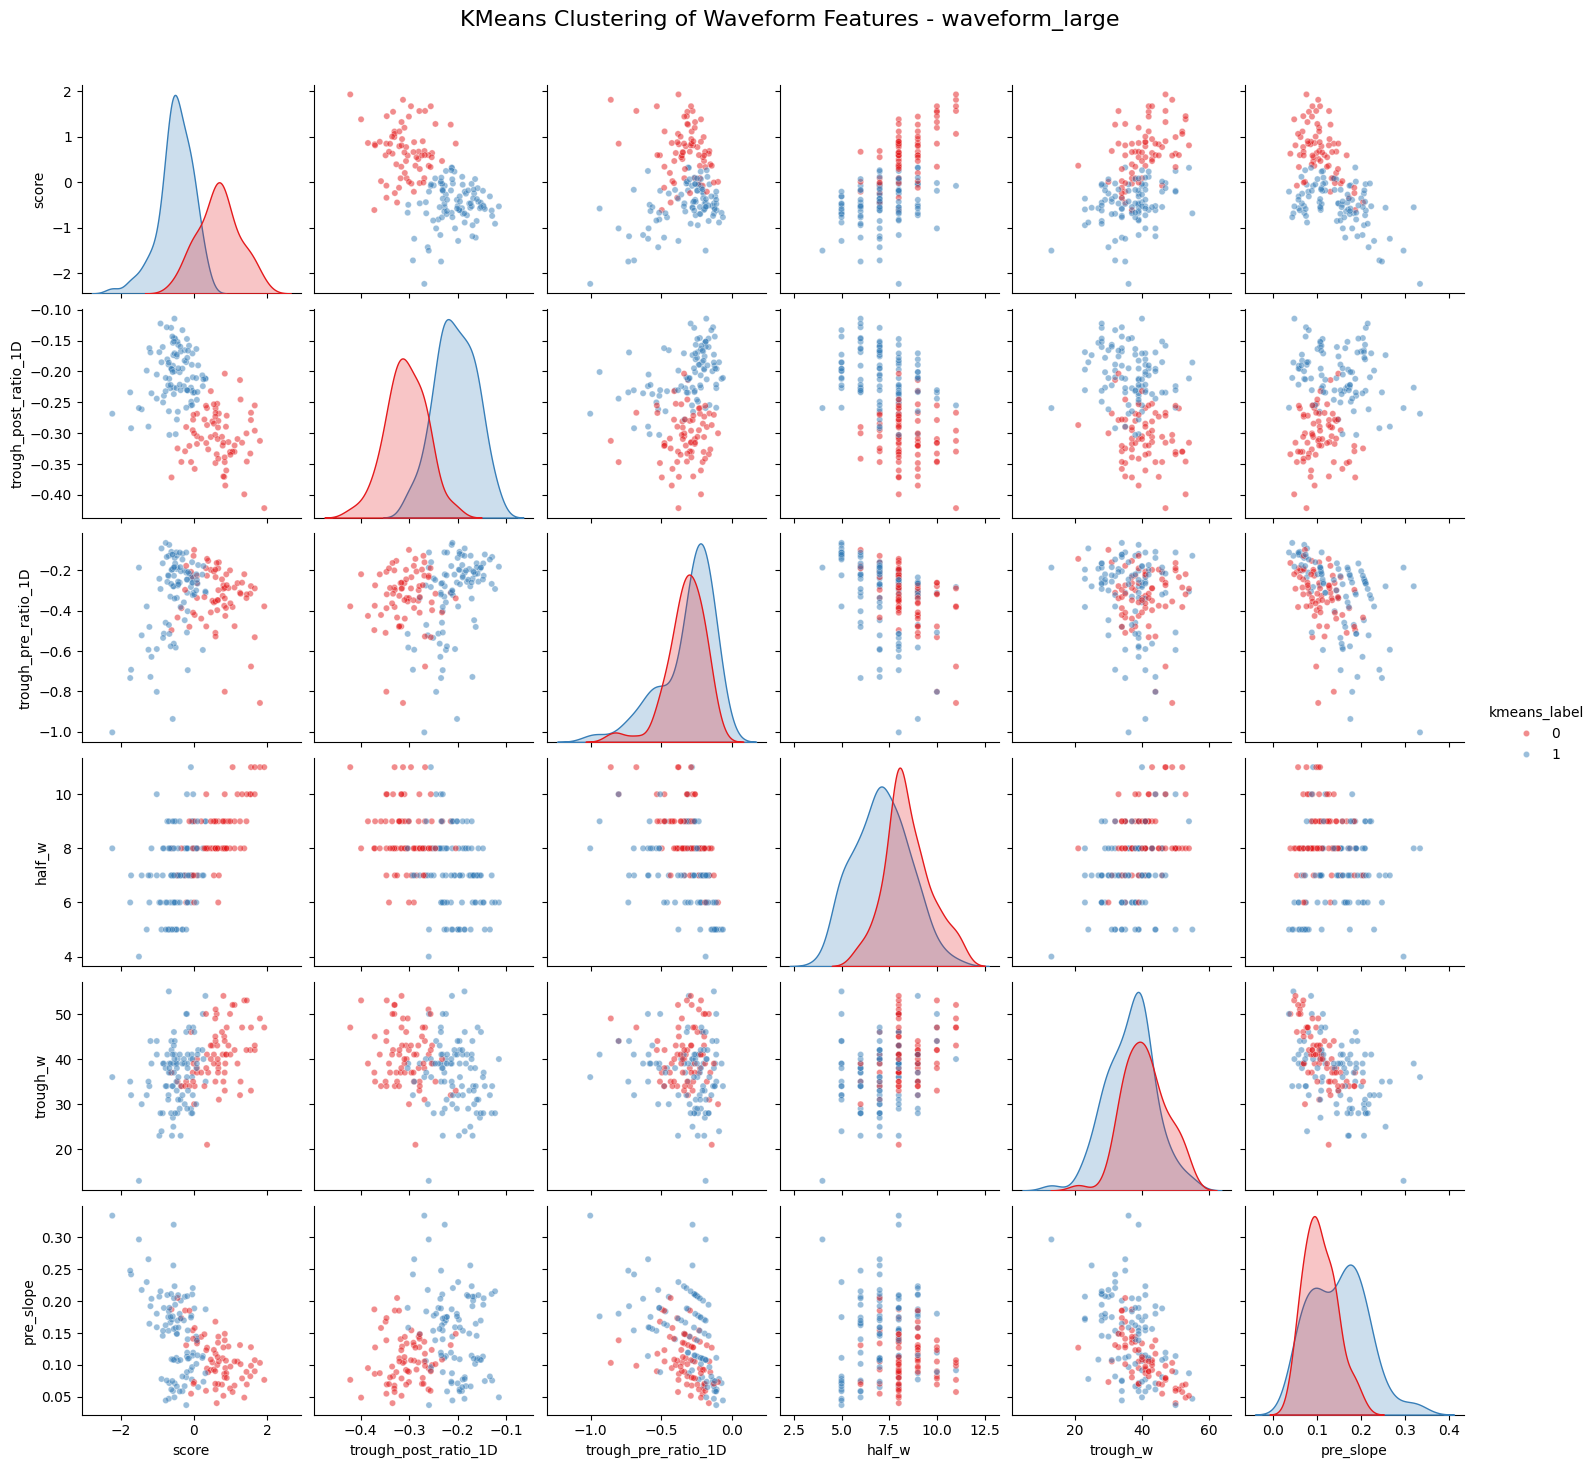

In [ ]:
from sklearn.cluster import KMeans

# Perform KMeans clustering using features from wf_features
kmeans = KMeans(n_clusters=2, random_state=4, n_init='auto')  # Adjust n_init for sklearn >= 1.2
feature_list = ['score', 'trough_post_ratio_1D']
zscore_feature = zscore(feature[feature_list], axis=0, nan_policy='omit')

# Fit KMeans and assign cluster labels
kmeans.fit(zscore_feature)
feature['kmeans_label'] = kmeans.labels_

# Plot the KMeans clusters
plt.figure(figsize=(8, 6))
g = sns.pairplot(
    data=feature,
    hue='kmeans_label',
    vars=['score', 'trough_post_ratio_1D', 'trough_pre_ratio_1D', 'half_w', 'trough_w', 'pre_slope'],
    palette='Set1',
    plot_kws={'alpha': 0.5, 's': 20}
)

# Add title and save plots
plt.suptitle(f'KMeans Clustering of Waveform Features - {criteria_name}', fontsize=16)
g.fig.subplots_adjust(top=0.93)  # Adjust to make room for title

g.savefig(os.path.join(wf_folder, f'KMeans_clustering_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')

# Save features with KMeans clustering applied
wf_features['kmeans_label'] = feature['kmeans_label']
wf_features.to_csv(os.path.join(wf_folder, 'wf_features.csv'), index=False)


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_ylim'

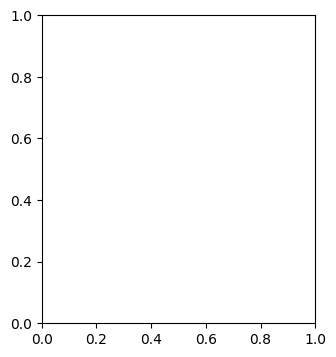

In [ ]:
fig = plt.figure(figsize=(12, 4))
wf_time = (np.arange(90) - 30)/30000 * 1000  # assuming 90 samples in the waveform
filter = feature['kmeans_label'] == 0  # filter for the first cluster
plt.subplot(1, 3, 1)
plt.set_ylim(-1, 1)
plt.plot(wf_time, all_wfs_aligned_nl[filter].T, alpha=0.2, linewidth=1, color='k');
plt.subplot(1, 3, 2)
plt.plot(wf_time, all_wfs_aligned_nl[~filter].T, alpha=0.2, linewidth=1, color=[0.5, 0.5, 0.5]);  # plot the ones with higher pca values in black
plt.set_ylim(-1, 1)
plt.subplot(1, 3, 3)
plt.set_ylim(-1, 1)
plt.plot(wf_time, np.mean(all_wfs_aligned_nl[filter], axis=0), linewidth=1, color='k');  # plot the ones with higher pca values in black
plt.plot(wf_time, np.mean(all_wfs_aligned_nl[~filter], axis=0), linewidth=1, color=[0.5, 0.5, 0.5]);
title = f"{len(all_wfs_nl_clean)} units, ISI violations < {constraints['isi_violations']['bounds'][1]}, peak < {constraints['peak']['bounds'][1]} uV"
plt.suptitle(title, fontsize=16)
plt.savefig(fname=os.path.join(wf_folder, f'Clusters_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')

if 'anti_resp' in combined_tagged_units_filtered.columns:
    plt.subplot(1, 3, 1)
    plt.plot(wf_time, all_wfs_aligned_nl[filter & (combined_tagged_units_filtered['anti_resp'] == 1) & (wf_features['gmm_conf']>0.9)].T, alpha=0.8, linewidth=1, color='r');
    plt.set_ylim(-1, 1)
    plt.subplot(1, 3, 2)
    plt.plot(wf_time, all_wfs_aligned_nl[~filter & (combined_tagged_units_filtered['anti_resp'] == 1) & (wf_features['gmm_conf']>0.9)].T, alpha=0.8, linewidth=1, color='r');  # plot the ones with higher pca values in black
    plt.set_ylim(-1, 1)
plt.savefig(fname=os.path.join(wf_folder, f'Clusters_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')

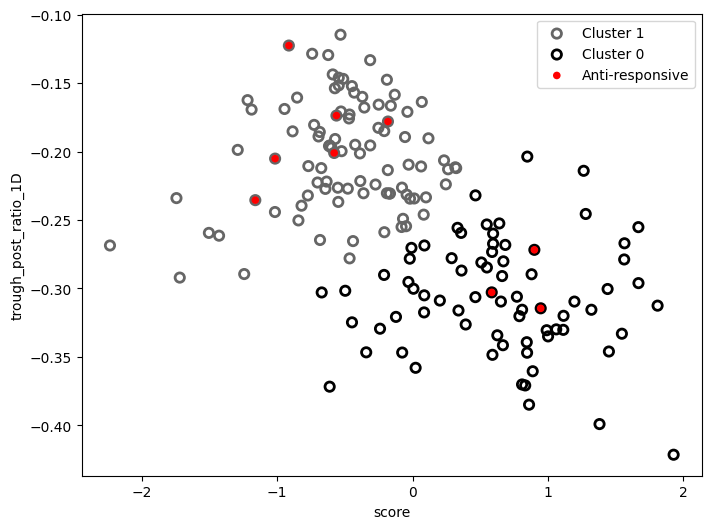

In [ ]:
x_feature = 'score'
y_feature = 'trough_post_ratio_1D'
plt.figure(figsize=(8, 6))
colors =  [[0, 0, 0], [0.4, 0.4, 0.4]]
for i, label in enumerate(feature['gmm_label'].unique()):
    subset = feature[feature['gmm_label'] == label]
    plt.scatter(subset[x_feature], subset[y_feature], facecolors='none', label=f'Cluster {label}', edgecolors = colors[label], s = 45, linewidths=2)
if 'anti_resp' in combined_tagged_units_filtered.columns:
    subset = feature[combined_tagged_units_filtered['anti_resp'] == 1 & (wf_features['gmm_conf']>0.9)]
    plt.scatter(subset[x_feature], subset[y_feature], facecolors='red', edgecolors='none', s=30, linewidths=2, label='Anti-responsive')
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.legend()
plt.savefig(os.path.join(wf_folder, f'{x_feature}_{y_feature}_gmm_clustering_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')

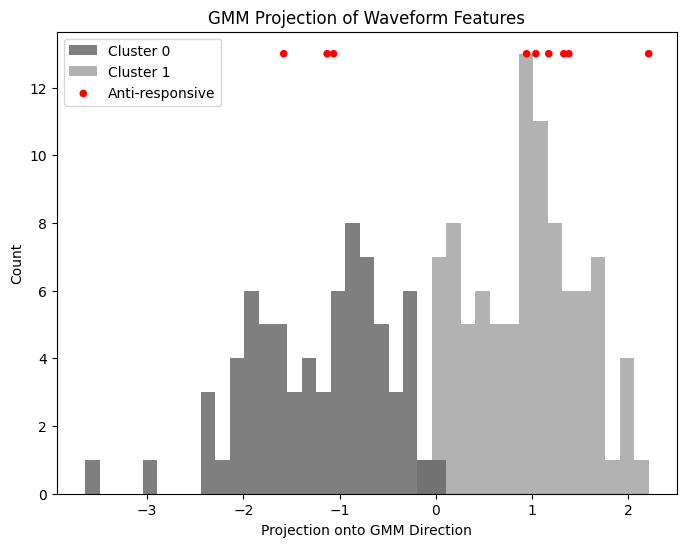

In [ ]:
# Compute projection direction: vector between the two GMM means
mean_diff = gmm.means_[1] - gmm.means_[0]
projection_direction = mean_diff / np.linalg.norm(mean_diff)  # Normalize

# Project all points onto that direction
projected_values = zscore_feature @ projection_direction
feature['gmm_projection'] = projected_values

# Plot the projection
plt.figure(figsize=(8, 6))
bins = np.linspace(np.min(projected_values), np.max(projected_values), 40)
plt.hist(projected_values[feature['gmm_label'] == 0], bins=bins, color=colors[0], alpha=0.5, label='Cluster 0')
plt.hist(projected_values[feature['gmm_label'] == 1], bins=bins, color= colors[1], alpha=0.5, label='Cluster 1')
plt.xlabel('Projection onto GMM Direction')
plt.ylabel('Count')
plt.title('GMM Projection of Waveform Features')

# scatter the anti-responsive units
if 'anti_resp' in combined_tagged_units_filtered.columns:
    anti_resp = feature[(combined_tagged_units_filtered['anti_resp'] == 1) & (wf_features['gmm_conf']>0.9)]
    plt.scatter(anti_resp['gmm_projection'], np.zeros_like(anti_resp['gmm_projection'])+13, color='red', label='Anti-responsive', s=30, edgecolors='none')

plt.legend()
plt.savefig(os.path.join(wf_folder, f'GMM_projection_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')


In [ ]:
# grab all tagged units and combine a pdf
data_type = 'curated'
target = 'soma'
selected_sessions = []
selected_units = []
all_pdf = []
for session, unit, tag, qc in zip(all_sessions, all_units, all_tagged_units, all_qc_pass_units):
    if tag and qc:
        session_dir = session_dirs(session)
        # # opto_file
        # all_pdfs = os.listdir(session_dir[f'opto_dir_fig_{data_type}'])
        # pdf = [pdf for pdf in all_pdfs if f'unit_{unit}_' in pdf and pdf.endswith('.pdf')][0]
        # pdf_path = os.path.join(session_dir[f'opto_dir_fig_{data_type}'], pdf)
        # # copy to new path
        # new_path_opto = os.path.join('/root/capsule/scratch/combined/opto_tagged', f'{session}_{pdf}')
        # _ = shutil.copy(pdf_path, new_path_opto)

        # selected_sessions.append(session)
        # selected_units.append(unit)
        # all_pdf.append(pdf_path)

        # # behavior file: go cue
        # all_pdfs = os.listdir(os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'go_cue'))
        # pdf = [pdf for pdf in all_pdfs if f'unit_{unit}_' in pdf and pdf.endswith('.pdf')][0]
        # pdf_path = os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'go_cue', pdf)
        # # copy to new path
        # new_path_ephys = os.path.join('/root/capsule/scratch/combined/behavior_tagged_go_cue', f'{session}_{pdf}')
        # _ = shutil.copy(pdf_path, new_path_ephys)

        # behavior file: go cue
        all_pdfs = os.listdir(os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'response'))
        pdf = [pdf for pdf in all_pdfs if f'unit_{unit}_' in pdf and pdf.endswith('.pdf')][0]
        pdf_path = os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'response', pdf)
        # copy to new path
        new_path_ephys = os.path.join('/root/capsule/scratch/combined/behavior_tagged_response', f'{session}_{pdf}')
        _ = shutil.copy(pdf_path, new_path_ephys)


NameError: name 'all_sessions' is not defined

In [ ]:
opto_sessions = []
for session, unit, tag, qc in zip(all_sessions, all_units, all_tagged_units, all_qc_pass_units):
    if tag and qc:
        opto_sessions.append(session)

opto_sessions = list(set(opto_sessions))

for session in opto_sessions:
    session_dir = session_dirs(session)
    opto_summary_file = os.path.join(session_dir[f'opto_dir_{data_type}'], f"{session}_{data_type}_{target}_opto_summary.pdf")
    if os.path.exists(opto_summary_file):
        new_path = os.path.join('/root/capsule/scratch/combined/opto_summary', f'{session}_opto_summary.pdf')
        _ = shutil.copy(opto_summary_file, new_path)


In [ ]:
opto_sessions = []
for session, unit, tag, qc in zip(all_sessions, all_units, all_tagged_units, all_qc_pass_units):
    if tag and qc:
        opto_sessions.append(session)

opto_sessions = list(set(opto_sessions))

for session in opto_sessions:
    session_dir = session_dirs(session)
    waveform_summary_file = os.path.join(session_dir[f'ephys_dir_{data_type}'], "waveforms_recompute.pdf")
    if os.path.exists(waveform_summary_file):
        new_path = os.path.join('/root/capsule/scratch/combined/waveform_summary', f'{session}_waveform_recompute.pdf')
        _ = shutil.copy(waveform_summary_file, new_path)

In [ ]:
# combine_pdf_big('/root/capsule/scratch/combined/opto_tagged', os.path.join('/root/capsule/scratch/combined', 'opto_tagged_combined.pdf'))
# combine_pdf_big('/root/capsule/scratch/combined/behavior_tagged_go_cue', os.path.join('/root/capsule/scratch/combined', 'behavior_ephys_tagged_go_cue_combined.pdf'))

# combine_pdf_big('/root/capsule/scratch/combined/behavior_tagged_response', os.path.join('/root/capsule/scratch/combined', 'behavior_ephys_tagged_response_combined.pdf'))
combine_pdf_big('/root/capsule/scratch/combined/opto_summary', os.path.join('/root/capsule/scratch/combined', 'opto_probe_summary.pdf'))

Processing 23 files in /root/capsule/scratch/combined/opto_summary


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97392750 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97392750 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97392750 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97392750 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (97392750 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS 

Combined PDF saved as: /root/capsule/scratch/combined/opto_probe_summary.pdf
